# Constructing Data

Calculate bond factors

author: Maris

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns

In [3]:
from scipy.optimize import newton
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [7]:
pd.set_option('display.max_columns', None)

In [8]:
os.chdir('/Users/maris/Documents/FE800')

## Import Data

In [9]:
raw_data = pd.read_pickle("raw_data.pkl")
raw_data = raw_data.sort_values("trd_datetime")
raw_data.head()

cusip_id  bond_sym_id company_symbol          bsym trd_exctn_dt  \
15069458  871829BF3   SYY4509019            SYY  BBG00GZTSD12   2018-07-01   
13757251  98978VAL7   PFE4538719            PFE  BBG00HMQT197   2018-07-02   
168819    037833DB3  AAPL4538816           AAPL  BBG00HMQPZ05   2018-07-02   
12504563  606822AR5   MTU4520249            MTU  BBG00H5RFN00   2018-07-02   
3857278   172967KA8     C4292071              C  BBG00B2XQKX1   2018-07-02   

         trd_exctn_tm   trans_dt  msg_seq_nb trc_st remuneration  \
15069458     23:50:32 2018-07-02         499      M            M   
13757251     01:17:48 2018-07-02         502      M            M   
168819       02:37:16 2018-07-02         124      M            M   
12504563     02:43:56 2018-07-02         503      M            M   
3857278      03:35:11 2018-07-02         574      M            M   

          ascii_rptd_vol_tx frmt_cd  rptd_pr yld_sign_cd    yld_pt asof_cd  \
15069458          5000000.0       A   94.111         NaN  4.034690       A   
13757251          5000000.0       A   92.248         NaN  4.017301     NaN   
168819              10000.0       A   95.090         NaN  3.530293     NaN   
12504563           100000.0       A   95.448         NaN  3.887961     NaN   
3857278            110000.0       A   98.817         NaN  4.607907     NaN   

         sale_cndtn_cd sale_cndtn2_cd spcl_trd_fl side  chng_cd  rptd_high_pr  \
15069458           NaN            NaN         NaN    S        0           NaN   
13757251           NaN            NaN         NaN    S        7           NaN   
168819             NaN            NaN         NaN    S        7           NaN   
12504563           NaN            NaN         NaN    S        7           NaN   
3857278            NaN            NaN         NaN    S        2           NaN   

          high_yld_pt  rptd_low_pr  low_yld_pt  rptd_last_pr  lsal_yld_pt  \
15069458          NaN          NaN         NaN           NaN          NaN   
13757251          NaN          NaN         NaN           NaN          NaN   
168819            NaN          NaN         NaN           NaN          NaN   
12504563          NaN          NaN         NaN           NaN          NaN   
3857278           NaN          NaN         NaN           NaN          NaN   

         orig_dis_dt  orig_msg_seq_nb function rptg_party_type  \
15069458         NaN              NaN      NaN               D   
13757251         NaN              NaN      NaN               D   
168819           NaN              NaN      NaN               D   
12504563         NaN              NaN      NaN               D   
3857278          NaN              NaN      NaN               D   

         contra_party_type        trd_datetime  
15069458                 C 2018-07-01 23:50:32  
13757251                 C 2018-07-02 01:17:48  
168819                   C 2018-07-02 02:37:16  
12504563                 A 2018-07-02 02:43:56  
3857278                  A 2018-07-02 03:35:11

In [10]:
data = raw_data[["cusip_id", "trd_datetime", "trans_dt", "rptd_pr", "ascii_rptd_vol_tx"]]
data = data.rename(columns = {"cusip_id":"cusip", "rptd_pr":"trd_px", "ascii_rptd_vol_tx":"volume", "trans_dt":"trd_dt"})
data = data.reset_index().drop(["index"], axis = 1)
data.head()

cusip        trd_datetime     trd_dt  trd_px     volume
0  871829BF3 2018-07-01 23:50:32 2018-07-02  94.111  5000000.0
1  98978VAL7 2018-07-02 01:17:48 2018-07-02  92.248  5000000.0
2  037833DB3 2018-07-02 02:37:16 2018-07-02  95.090    10000.0
3  606822AR5 2018-07-02 02:43:56 2018-07-02  95.448   100000.0
4  172967KA8 2018-07-02 03:35:11 2018-07-02  98.817   110000.0

In [11]:
df_characteristics = pd.read_pickle("df_characteristics.pkl")
df_characteristics = df_characteristics.drop(["Notional", "Par", "Liquidity_Score"], axis = 1)
df_characteristics.head()

Name      Cusip   Maturity      TTM  Coupon  \
0  PFIZER INVESTMENT ENTERPRISES PTE  716973AG7 2053-05-19  29.4438    5.30   
1       ANHEUSER-BUSCH COMPANIES LLC  03522AAJ9 2046-02-01  22.1452    4.90   
2        GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.8027    6.75   
3                    CVS HEALTH CORP  126650CZ1 2048-03-25  24.2904    5.05   
4                   T-MOBILE USA INC  87264ABF1 2030-04-15   6.3342    3.88   

   Weight  Amount_Issued               Industry       Location Accrual_Date  \
0    0.30     6000000000  Consumer Non-Cyclical  United States   2023-05-19   
1    0.28     9518964000  Consumer Non-Cyclical        Belgium   2019-02-01   
2    0.25     5545000000                Banking  United States   2007-10-03   
3    0.22     8000000000  Consumer Non-Cyclical  United States   2018-03-09   
4    0.21     7000000000         Communications  United States   2021-04-15   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2023-05-19           A1         A+            A    20+ Years   0.5781   
1     2019-05-13           A3         A-         None    20+ Years   4.5973   
2     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.2137   
3     2018-03-09         Baa2        BBB         None    20+ Years   5.7753   
4     2021-05-21         Baa2        BBB         BBB+    5-7 Years   2.5726   

          Company Ticker            Sector Sector Ticker  
0          Pfizer    PFE       Health Care           XLF  
1  Anheuser-Busch    BUD  Consumer Staples           XLV  
2   Goldman Sachs     GS        Financials           XLK  
3      Cvs Health    CVS       Health Care           XLF  
4    T-Mobile Usa   TMUS    Communications           XLY

In [12]:
macro_factors = pd.read_pickle("macro_factors.pkl")
macro_factors.head()

EFFR  Lower_Target  Upper_Target  1YRT  2YRT  3YRT  5YRT  7YRT  \
2018-07-02  1.91          1.75           2.0  2.34  2.57  2.65  2.75  2.83   
2018-07-03  1.91          1.75           2.0  2.33  2.53  2.63  2.72  2.79   
2018-07-05  1.91          1.75           2.0  2.32  2.55  2.65  2.74  2.80   
2018-07-06  1.91          1.75           2.0  2.34  2.53  2.64  2.71  2.78   
2018-07-09  1.91          1.75           2.0  2.34  2.57  2.66  2.75  2.82   

            10YRT  30YRT         SPY         LQD  
2018-07-02   2.87   2.99  271.859985  114.239998  
2018-07-03   2.83   2.96  270.899994  114.660004  
2018-07-05   2.84   2.95  273.109985  115.019997  
2018-07-06   2.82   2.94  275.420013  115.180000  
2018-07-09   2.86   2.96  277.899994  115.260002

In [13]:
df_close = pd.read_pickle("df_close.pkl")
df_close.head()

AAPL       ABBV        ABT       ACGL        ADBE  \
Date                                                                          
2018-07-02 00:00:00  44.601753  72.200836  55.612396  26.629999  243.259995   
2018-07-03 00:00:00  43.824955  72.588539  55.439167  26.760000  242.009995   
2018-07-05 00:00:00  44.177612  73.263191  55.913258  26.930000  244.179993   
2018-07-06 00:00:00  44.790005  75.155243  56.669945  27.280001  248.190002   
2018-07-09 00:00:00  45.411922  75.248314  56.925205  27.889999  249.770004   

                           ADI        ADM         ADP        ADSK        AEE  \
Date                                                                           
2018-07-02 00:00:00  86.700455  39.027901  120.220154  131.899994  52.755177   
2018-07-03 00:00:00  85.080063  39.398937  119.150444  131.600006  52.763802   
2018-07-05 00:00:00  86.781487  39.985699  119.195000  132.800003  53.039543   
2018-07-06 00:00:00  87.501633  40.304955  119.649620  135.110001  53.453186   
2018-07-09 00:00:00  87.483643  40.788166  119.917068  134.970001  51.678013   

                           AEP        AER        AES        AGR        AIG  \
Date                                                                         
2018-07-02 00:00:00  57.899601  53.770000  11.096851  42.949409  45.763748   
2018-07-03 00:00:00  58.271557  54.139999  10.987064  43.103031  46.029606   
2018-07-05 00:00:00  58.792274  54.480000  10.953284  43.394104  46.244019   
2018-07-06 00:00:00  59.147694  54.590000  10.978619  43.766029  46.629955   
2018-07-09 00:00:00  56.924278  55.349998  10.666152  42.221718  47.650543   

                            AL        ALL       ALLY       AMAT      AMCR  \
Date                                                                        
2018-07-02 00:00:00  37.819267  80.174446  22.660582  42.707485  8.176138   
2018-07-03 00:00:00  37.954823  80.375603  22.575615  41.884735  7.903599   
2018-07-05 00:00:00  38.207848  80.410599  22.771029  42.483093  8.082694   
2018-07-06 00:00:00  38.117481  80.603004  22.898483  43.128197  8.137202   
2018-07-09 00:00:00  38.894650  81.862442  23.552727  43.492821  8.137202   

                           AMGN         AMP         AMT       AMZN  \
Date                                                                 
2018-07-02 00:00:00  156.854813  125.273613  128.505905  85.689003   
2018-07-03 00:00:00  157.210358  123.824074  127.049103  84.697998   
2018-07-05 00:00:00  158.607117  125.362549  129.394135  84.986504   
2018-07-06 00:00:00  161.696960  125.993950  129.518524  85.531502   
2018-07-09 00:00:00  164.372025  129.622192  126.294060  86.950996   

                            AON         APD        APH       APTV      ARCC  \
Date                                                                          
2018-07-02 00:00:00  130.580246  137.692123  41.299656  90.947891  9.700124   
2018-07-03 00:00:00  130.418442  137.258179  41.110012  89.724068  9.700124   
2018-07-05 00:00:00  131.503082  137.957718  41.631523  91.855873  9.723710   
2018-07-06 00:00:00  132.835007  138.710434  41.811687  93.030365  9.729606   
2018-07-09 00:00:00  135.603638  139.817352  42.371143  94.283798  9.770883   

                            ARE  ATH-PA        ATO  ATVI        AVGO  \
Date                                                                   
2018-07-02 00:00:00  107.354965     NaN  79.224205   NaN  202.352249   
2018-07-03 00:00:00  108.183533     NaN  80.039772   NaN  200.044891   
2018-07-05 00:00:00  109.037727     NaN  80.723816   NaN  205.152771   
2018-07-06 00:00:00  109.054817     NaN  81.179832   NaN  207.058853   
2018-07-09 00:00:00  109.507530     NaN  78.759415   NaN  206.849884   

                           AWK        AXP        AZN         AZO          BA  \
Date                                                                           
2018-07-02 00:00:00  78.494125  91.516808  30.145588  667.809998  323.468414   
2018-07-03 00:00:00  79.012497  90

In [14]:
df_volume = pd.read_pickle("df_volume.pkl")
df_volume.head()

AAPL     ABBV      ABT     ACGL     ADBE      ADI  \
Date                                                                         
2018-07-02 00:00:00  70925200  3854500  4365200  1249400  4127400  2058400   
2018-07-03 00:00:00  55819200  2452400  2245200   537300  1307700   876000   
2018-07-05 00:00:00  66416800  4744000  4065200   926200  1863400  1977700   
2018-07-06 00:00:00  69940800  5867400  3647900  1482600  1889700  1551000   
2018-07-09 00:00:00  79026400  5953100  3654900  1858000  2170700  1861300   

                         ADM      ADP     ADSK      AEE      AEP      AER  \
Date                                                                        
2018-07-02 00:00:00  3800100  2228800  1308300  1203500  2211700  1224800   
2018-07-03 00:00:00  1508000  2794200   928100   677000  2132100   509300   
2018-07-05 00:00:00  2556000  2593400  1708200  1046500  4157000  1197000   
2018-07-06 00:00:00  2306800  3895900  1159200  1171600  2315100   824600   
2018-07-09 00:00:00  3410300  2750300  1761500  1782100  4302600   941600   

                         AES     AGR      AIG      AL      ALL     ALLY  \
Date                                                                      
2018-07-02 00:00:00  7761300  305500  5198800  811000  1789500  4001000   
2018-07-03 00:00:00  3846200  255500  1970500  359300   836500  1143100   
2018-07-05 00:00:00  5292000  483300  2743800  597300  1133800  2933200   
2018-07-06 00:00:00  5476100  311500  2212400  323500  1559600  2047500   
2018-07-09 00:00:00  7724900  616400  4706400  379900  1391200  3105200   

                         AMAT  AMCR     AMGN      AMP      AMT      AMZN  \
Date                                                                       
2018-07-02 00:00:00  11042900     0  2069800   721400  1559500  63714000   
2018-07-03 00:00:00   7538500   900  1348000   337400  1669600  43546000   
2018-07-05 00:00:00   8950700   700  1801000   996700  1512400  59662000   
2018-07-06 00:00:00  11467600   100  2751600   988600  1376600  53006000   
2018-07-09 00:00:00   9727700     0  3065500  1217600  2334400  60240000   

                        AON      APD      APH     APTV     ARCC     ARE  \
Date                                                                      
2018-07-02 00:00:00  777600  1110100  2303000  1684400  3165900  542700   
2018-07-03 00:00:00  411000   346800   859200   867800   684500  319600   
2018-07-05 00:00:00  710800  1140600  1557200  1824600  1304500  825000   
2018-07-06 00:00:00  837400   718800  1623600  1390900  1880700  480300   
2018-07-09 00:00:00  984600   744100  1627400  1317000  1953600  769000   

                     ATH-PA     ATO     AVGO     AWK      AXP      AZN  \
Date                                                                     
2018-07-02 00:00:00     NaN  353200  3336900  674900  3148700  4119700   
2018-07-03 00:00:00     NaN  373600  1159100  336000  2041200  1909600   
2018-07-05 00:00:00     NaN  328000  2529900  682700  2385500  3715700   
2018-07-06 00:00:00     NaN  271100  2311200  608300  1996600  2736100   
2018-07-09 00:00:00     NaN  564400  1795500  869400  4991700  2062500   

                        AZO       BA       BAC  BAM      BAX    BBAR      BCE  \
Date                                                                            
2018-07-02 00:00:00  317000  2820700  52534300  NaN  1391900  942900   654100   
2018-07-03 00:00:00  143400  1464400  40599000  NaN  1531800  647000   605800   
2018-07-05 00:00:00  144100  2427900  44506800  NaN  1595700  619700  1541800   
2018-07-06 00:00:00  145700  2105100  39424900  NaN  1440100  282000  1442200   
2018-07-09 00:00:00  218000  3128700  61758900  NaN  1564500  361900   843800   

                         BCS     BDX       BG      BHF      BHP      BIIB  \
Date                                                                        
2018-07-02 00:00:00  2289600  827893  1032300  2140000  3397751   1116400   
2018-07-03 00:00:00  1433000  69679

In [15]:
df_sector_etfs = pd.read_pickle("df_sector_etfs.pkl")
df_sector_etfs = df_sector_etfs.drop([pd.Timestamp("2022-12-30")])
df_sector_etfs.head()

XLB        XLC        XLE        XLF        XLI        XLK  \
Date                                                                           
2018-07-02  51.815948  47.558670  57.704597  23.967850  65.343201  66.198051   
2018-07-03  51.726242  46.976601  58.067085  23.752569  65.133865  65.414131   
2018-07-05  52.174778  47.692268  58.005360  23.806389  65.452423  66.339706   
2018-07-06  52.434937  48.446098  58.360146  23.922997  65.679977  67.114197   
2018-07-09  52.901424  48.722832  59.231670  24.470169  66.899635  67.624207   

                  XLP       XLRE        XLU        XLV         XLY  
Date                                                                
2018-07-02  44.529396  27.259001  44.282070  76.473450  103.793663  
2018-07-03  44.633705  27.418257  44.409012  76.656128  103.272102  
2018-07-05  45.250839  27.778692  44.645935  77.450821  103.784195  
2018-07-06  45.389912  27.896044  44.992889  78.565239  104.599754  
2018-07-09  45.216080  27.636198  43.605114  79.140694  105.851540

# Clean Data

## Convert Raw Trades to Daily Data

In [16]:
data['Volume Weighted'] = data['trd_px'] * data["volume"]
data = data.replace(9920.000, 99.2)
data.head()

cusip        trd_datetime     trd_dt  trd_px     volume  \
0  871829BF3 2018-07-01 23:50:32 2018-07-02  94.111  5000000.0   
1  98978VAL7 2018-07-02 01:17:48 2018-07-02  92.248  5000000.0   
2  037833DB3 2018-07-02 02:37:16 2018-07-02  95.090    10000.0   
3  606822AR5 2018-07-02 02:43:56 2018-07-02  95.448   100000.0   
4  172967KA8 2018-07-02 03:35:11 2018-07-02  98.817   110000.0   

   Volume Weighted  
0      470555000.0  
1      461240000.0  
2         950900.0  
3        9544800.0  
4       10869870.0

In [17]:
daily_close_prices = data.groupby(["cusip", "trd_dt"]).agg({"volume": ["sum", "count"], "Volume Weighted":"sum"})
daily_close_prices.columns = ["volume", "Trades", "Volume Weighted"]
daily_close_prices["Price"] = daily_close_prices["Volume Weighted"]/daily_close_prices["volume"]
daily_close_prices.head()

volume  Trades  Volume Weighted       Price
cusip     trd_dt                                                     
00130HCG8 2021-08-16   5000000.0       1     5.053350e+08  101.067000
          2021-08-20    190000.0       2     1.915027e+07  100.790895
          2021-08-23   7324000.0       3     7.418814e+08  101.294571
          2021-08-24   5066000.0       4     5.123338e+08  101.131820
          2021-08-25  12913000.0       6     1.302462e+09  100.864373

In [18]:
df_daily = daily_close_prices[["Price"]].unstack("cusip")
df_daily = df_daily.sort_index()
df_daily.columns = df_daily.columns.droplevel(0)
df_daily = df_daily.replace(.1, 147.647)
df_daily = df_daily.ffill()
df_daily.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN  85.754886  85.384031  92.665417  90.208934   
2018-07-03        NaN        NaN  86.513796  85.764063  92.777224  90.303485   
2018-07-05        NaN        NaN  86.808383  85.934335  93.232962  90.663970   
2018-07-06        NaN        NaN  87.240021  86.341765  93.660107  91.439949   
2018-07-09        NaN        NaN  87.150785  86.970850  94.223017  91.555884   

cusip        00206RCU4  00206RDJ8  00206RDK5  00206RDQ2   00206RDR0  \
trd_dt                                                                
2018-07-02  100.567545  86.122095  86.578555  98.079399   98.915105   
2018-07-03  101.560580  86.711487  86.373563  98.487451   99.702791   
2018-07-05  102.412667  87.573431  87.524091  98.580550   99.926073   
2018-07-06  102.412667  87.806941  87.825117  98.839170  100.405647   
2018-07-09  102.521000  88.317067  87.825117  98.883799  100.147121   

cusip       00206RGL0  00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJY9  00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKH4  00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RMT6  00217GAB9  00217GAC7  002824BF6   002824BG4  \
trd_dt                                                               
2018-07-02        NaN        NaN        NaN  98.347100  105.663436   
2018-07-03        NaN        NaN        NaN  98.607547  106.012000   
2018-07-05        NaN        NaN        NaN  98.716870  106.840000   
2018-07-06        NaN        NaN        NaN  99.016126  106.974145   
2018-07-09        NaN        NaN        NaN  98.918538  107.060403   

cusip        002824BH2  00287YAM1  00287YAR0  00287YAS8  00287YAV1  00287YAW9  \
trd_dt                                                                          
2018-07-02  107.717256  95.297024  98.134277  99.311712  95.421043  95.210000   
2018-07-03  108.658022  95.393000  98.154614  99.311712  96.096748  95.210000   
2018-07-05  109.135716  96.071741  99.184341  99.991470  96.262823  96.482000   
2018-07-06  109.874550  96.071741  99.318500  99.991470  96.777099  96.846005   
2018-07-09  109.923346  96.822787  99.148051  99.991470  97.550418  96.905000   

cusip       00287YBD0  00287YBF5  00287YBV0  00287YBX6  00287YCA5  00287YCB3  \
trd_dt                                                                         
2018-07-02        NaN        NaN       

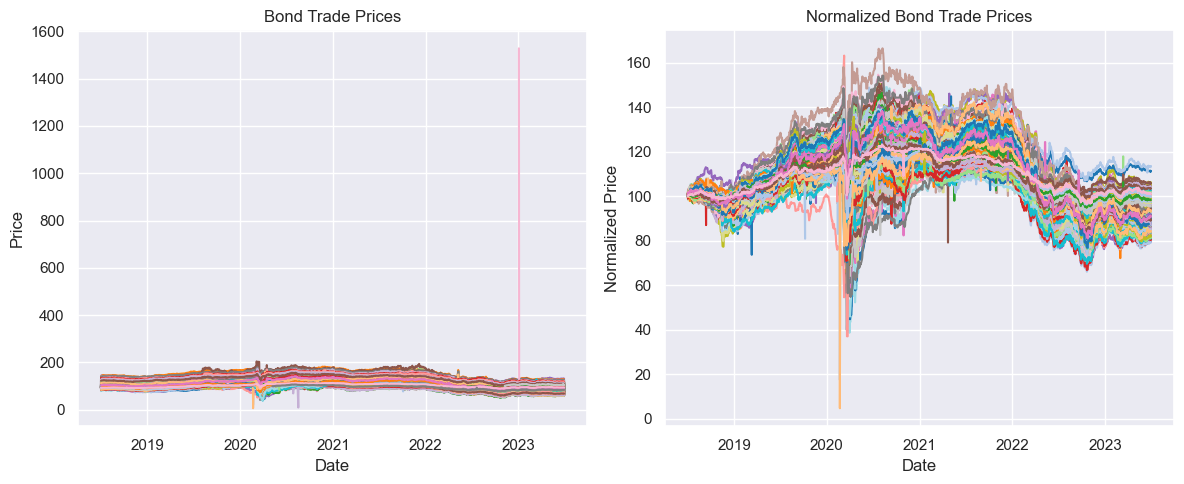

In [19]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_daily)
ax[0].set_title("Bond Trade Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

ax[1].plot(df_daily/df_daily.iloc[0] * 100)
ax[1].set_title("Normalized Bond Trade Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [20]:
df_daily_returns = df_daily.pct_change()
df_daily_returns = df_daily_returns[df_characteristics[df_characteristics["Cusip"].isin(df_daily_returns.columns)].sort_values("Cusip")["Cusip"]]
df_daily_returns.head()

cusip       00130HCG8  00130HCH6  00206RBH4  00206RBK7  00206RCP5  00206RCQ3  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.008850   0.004451   0.001207   0.001048   
2018-07-05        NaN        NaN   0.003405   0.001985   0.004912   0.003992   
2018-07-06        NaN        NaN   0.004972   0.004741   0.004581   0.008559   
2018-07-09        NaN        NaN  -0.001023   0.007286   0.006010   0.001268   

cusip       00206RCU4  00206RDJ8  00206RDK5  00206RDQ2  00206RDR0  00206RGL0  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.009874   0.006844  -0.002368   0.004160   0.007963        NaN   
2018-07-05   0.008390   0.009940   0.013320   0.000945   0.002239        NaN   
2018-07-06   0.000000   0.002666   0.003439   0.002623   0.004799        NaN   
2018-07-09   0.001058   0.005810   0.000000   0.000452  -0.002575        NaN   

cusip       00206RGQ9  00206RHJ4  00206RHK1  00206RHW5  00206RJX1  00206RJY9  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RJZ6  00206RKA9  00206RKB7  00206RKE1  00206RKG6  00206RKH4  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00206RKJ0  00206RLJ9  00206RLV2  00206RMM1  00206RMN9  00206RMT6  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-09        NaN        NaN        NaN        NaN        NaN        NaN   

cusip       00217GAB9  00217GAC7  002824BF6  002824BG4  002824BH2  00287YAM1  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03        NaN        NaN   0.002648   0.003299   0.008734   0.001007   
2018-07-05        NaN        NaN   0.001109   0.007810   0.004396   0.007115   
2018-07-06        NaN        NaN   0.003031   0.001256   0.006770   0.000000   
2018-07-09        NaN        NaN  -0.000986   0.000806   0.000444   0.007818   

cusip       00287YAR0  00287YAS8  00287YAV1  00287YAW9  00287YBD0  00287YBF5  \
trd_dt                                                                         
2018-07-02        NaN        NaN        NaN        NaN        NaN        NaN   
2018-07-03   0.000207   0.000000   0.007081   0.000000        NaN        NaN   
2018-07-05   0.010491   0.006845   0.001728   0.013360        NaN        NaN   
2018-07-06   0.001353   0.000000   0.005342   0.003773        NaN        NaN   
2018-07-09  -0.001716   0.000000   0.007991   0.000609        NaN        NaN   

cusip       00287YBV0  00287YBX6  00287YCA5  00287YCB3  00287YCY3  00287Y

In [29]:
days = df_daily_returns.index.to_series().diff().dt.days
days.iloc[0] = 1
days = days/365
days

trd_dt
2018-07-02    0.002740
2018-07-03    0.002740
2018-07-05    0.005479
2018-07-06    0.002740
2018-07-09    0.008219
                ...   
2023-06-26    0.008219
2023-06-27    0.002740
2023-06-28    0.002740
2023-06-29    0.002740
2023-06-30    0.002740
Name: trd_dt, Length: 1257, dtype: float64

In [30]:
accrued_interest = pd.DataFrame(index=df_daily_returns.index, columns = df_daily_returns.columns)
accrued_interest.iloc[0] = df_characteristics[df_characteristics["Cusip"].isin(df_daily_returns.columns)].sort_values("Cusip")["Coupon"]/200
accrued_interest = accrued_interest.ffill()
accrued_interest = accrued_interest.apply(lambda col: col * days)/df_daily.shift(1).ffill().bfill()
accrued_interest.head()

cusip          00130HCG8     00130HCH6     00206RBH4     00206RBK7  \
trd_dt                                                               
2018-07-02  3.320732e-07  7.453968e-07  6.868892e-07  6.978944e-07   
2018-07-03  3.320732e-07  7.453968e-07  6.868892e-07  6.978944e-07   
2018-07-05  6.641464e-07  1.490794e-06  1.361728e-06  1.389604e-06   
2018-07-06  3.320732e-07  7.453968e-07  6.785532e-07  6.934253e-07   
2018-07-09  9.962197e-07  2.236190e-06  2.025588e-06  2.070459e-06   

cusip          00206RCP5     00206RCQ3     00206RCU4     00206RDJ8  \
trd_dt                                                               
2018-07-02  6.652302e-07  7.213087e-07  7.696047e-07  7.157726e-07   
2018-07-03  6.652302e-07  7.213087e-07  7.696047e-07  7.157726e-07   
2018-07-05  1.328857e-06  1.441107e-06  1.524159e-06  1.421815e-06   
2018-07-06  6.611807e-07  7.176886e-07  7.557391e-07  7.039102e-07   
2018-07-09  1.974496e-06  2.134794e-06  2.267217e-06  2.106115e-06   

cusip          00206RDK5     00206RDQ2     00206RDR0     00206RGL0  \
trd_dt                                                               
2018-07-02  7.199100e-07  5.935923e-07  7.270660e-07  5.694741e-07   
2018-07-03  7.199100e-07  5.935923e-07  7.270660e-07  5.694741e-07   
2018-07-05  1.443237e-06  1.182266e-06  1.442644e-06  1.138948e-06   
2018-07-06  7.121327e-07  5.905747e-07  7.197101e-07  5.694741e-07   
2018-07-09  2.129075e-06  1.767088e-06  2.148818e-06  1.708422e-06   

cusip          00206RGQ9     00206RHJ4     00206RHK1     00206RHW5  \
trd_dt                                                               
2018-07-02  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-03  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-05  1.265456e-06  1.196746e-06  1.389218e-06  1.019683e-06   
2018-07-06  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-09  1.898183e-06  1.795119e-06  2.083827e-06  1.529524e-06   

cusip          00206RJX1     00206RJY9     00206RJZ6     00206RKA9  \
trd_dt                                                               
2018-07-02  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-03  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-05  6.308772e-07  7.558698e-07  9.634433e-07  1.006695e-06   
2018-07-06  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-09  9.463158e-07  1.133805e-06  1.445165e-06  1.510042e-06   

cusip          00206RKB7     00206RKE1     00206RKG6     00206RKH4  \
trd_dt                                                               
2018-07-02  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-03  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-05  1.062604e-06  9.017578e-07  4.507716e-07  6.161382e-07   
2018-07-06  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-09  1.593906e-06  1.352637e-06  6.761574e-07  9.242072e-07   

cusip          00206RKJ0     00206RLJ9     00206RLV2     00206RMM1  \
trd_dt                                                               
2018-07-02  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-03  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-05  9.408031e-07  9.326928e-07  9.640966e-07  6.991265e-07   
2018-07-06  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-09  1.411205e-06  1.399039e-06  1.446145e-06  1.048690e-06   

cusip          00206RMN9     00206RMT6     00217GAB9     00217GAC7  \
trd_dt                                                               
2018-07-02  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-03  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-05  9.808193e-07  1.482786e-06  8.907634e-07  1.129693e-06   
2018-07-06  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-09  1.471229e-06  2.224179e-06  1.336145e-06  1.694539e-06   

cusip          002824BF6     002824BG4     002824BH2     00287YAM1  \
tr

In [31]:
total_returns = df_daily_returns.fillna(0) + accrued_interest
total_returns.head()

cusip          00130HCG8     00130HCH6     00206RBH4     00206RBK7  \
trd_dt                                                               
2018-07-02  3.320732e-07  7.453968e-07  6.868892e-07  6.978944e-07   
2018-07-03  3.320732e-07  7.453968e-07  8.850444e-03  4.451559e-03   
2018-07-05  6.641464e-07  1.490794e-06  3.406442e-03  1.986736e-03   
2018-07-06  3.320732e-07  7.453968e-07  4.972987e-03  4.741870e-03   
2018-07-09  9.962197e-07  2.236190e-06 -1.020851e-03  7.288057e-03   

cusip          00206RCP5     00206RCQ3     00206RCU4     00206RDJ8  \
trd_dt                                                               
2018-07-02  6.652302e-07  7.213087e-07  7.696047e-07  7.157726e-07   
2018-07-03  1.207233e-03  1.048855e-03  9.875072e-03  6.844391e-03   
2018-07-05  4.913498e-03  3.993363e-03  8.391463e-03  9.941796e-03   
2018-07-06  4.582148e-03  8.559564e-03  7.557391e-07  2.667146e-03   
2018-07-09  6.012110e-03  1.270019e-03  1.060079e-03  5.811738e-03   

cusip          00206RDK5     00206RDQ2     00206RDR0     00206RGL0  \
trd_dt                                                               
2018-07-02  7.199100e-07  5.935923e-07  7.270660e-07  5.694741e-07   
2018-07-03 -2.366976e-03  4.161013e-03  7.963985e-03  5.694741e-07   
2018-07-05  1.332181e-02  9.464769e-04  2.240915e-03  1.138948e-06   
2018-07-06  3.440064e-03  2.624031e-03  4.800008e-03  5.694741e-07   
2018-07-09  2.129075e-06  4.532976e-04 -2.572668e-03  1.708422e-06   

cusip          00206RGQ9     00206RHJ4     00206RHK1     00206RHW5  \
trd_dt                                                               
2018-07-02  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-03  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-05  1.265456e-06  1.196746e-06  1.389218e-06  1.019683e-06   
2018-07-06  6.327278e-07  5.983730e-07  6.946090e-07  5.098413e-07   
2018-07-09  1.898183e-06  1.795119e-06  2.083827e-06  1.529524e-06   

cusip          00206RJX1     00206RJY9     00206RJZ6     00206RKA9  \
trd_dt                                                               
2018-07-02  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-03  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-05  6.308772e-07  7.558698e-07  9.634433e-07  1.006695e-06   
2018-07-06  3.154386e-07  3.779349e-07  4.817217e-07  5.033475e-07   
2018-07-09  9.463158e-07  1.133805e-06  1.445165e-06  1.510042e-06   

cusip          00206RKB7     00206RKE1     00206RKG6     00206RKH4  \
trd_dt                                                               
2018-07-02  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-03  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-05  1.062604e-06  9.017578e-07  4.507716e-07  6.161382e-07   
2018-07-06  5.313021e-07  4.508789e-07  2.253858e-07  3.080691e-07   
2018-07-09  1.593906e-06  1.352637e-06  6.761574e-07  9.242072e-07   

cusip          00206RKJ0     00206RLJ9     00206RLV2     00206RMM1  \
trd_dt                                                               
2018-07-02  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-03  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-05  9.408031e-07  9.326928e-07  9.640966e-07  6.991265e-07   
2018-07-06  4.704015e-07  4.663464e-07  4.820483e-07  3.495633e-07   
2018-07-09  1.411205e-06  1.399039e-06  1.446145e-06  1.048690e-06   

cusip          00206RMN9     00206RMT6     00217GAB9     00217GAC7  \
trd_dt                                                               
2018-07-02  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-03  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-05  9.808193e-07  1.482786e-06  8.907634e-07  1.129693e-06   
2018-07-06  4.904097e-07  7.413931e-07  4.453817e-07  5.648463e-07   
2018-07-09  1.471229e-06  2.224179e-06  1.336145e-06  1.694539e-06   

cusip          002824BF6     002824BG4     002824BH2     00287YAM1  \
tr

## Select Bonds with Complete Data

In [32]:
df_characteristics_full = df_characteristics[df_characteristics["Effective_Date"] < pd.Timestamp("2018-07-01")]
df_characteristics_full = df_characteristics_full.reset_index().drop(["index"], axis = 1)
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  \
0         GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.8027    6.75   
1                     CVS HEALTH CORP  126650CZ1 2048-03-25  24.2904    5.05   
2  DEUTSCHE TELEKOM INTERNATIONAL FIN  25156PAC7 2030-06-15   6.5014    8.75   
3      BRITISH TELECOMMUNICATIONS PLC  111021AE1 2030-12-15   7.0027    9.63   
4                BANK OF AMERICA CORP  06051GHD4 2028-12-20   5.0164    3.42   

   Weight  Amount_Issued               Industry        Location Accrual_Date  \
0    0.25     5545000000                Banking   United States   2007-10-03   
1    0.22     8000000000  Consumer Non-Cyclical   United States   2018-03-09   
2    0.21     3500000000         Communications         Germany   2000-07-06   
3    0.16     2800000000         Communications  United Kingdom   2000-12-12   
4    0.15     5437485000                Banking   United States   2017-12-20   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.2137   
1     2018-03-09         Baa2        BBB         None    20+ Years   5.7753   
2     2000-07-06         Baa1       BBB+         BBB+    5-7 Years  23.4603   
3     2000-12-12         Baa2        BBB          BBB   7-10 Years  23.0247   
4     2018-05-22           A3       BBB+         None    5-7 Years   5.5726   

                          Company Ticker          Sector Sector Ticker  
0                   Goldman Sachs     GS      Financials           XLK  
1                      Cvs Health    CVS     Health Care           XLF  
2  Deutsche Telekom International  DTEGY  Communications           XLY  
3      British Telecommunications  BTGOF  Communications           XLY  
4                 Bank Of America    BAC      Financials           XLK

In [33]:
len(df_characteristics_full)

755

In [34]:
full_data = df_characteristics[df_characteristics["Effective_Date"] < pd.Timestamp("2018-07-01")]["Cusip"]
full_data = [i for i in full_data if i not in ['161175BK9', '161175BJ2']]

In [35]:
df_characteristics_full = df_characteristics_full[df_characteristics_full["Cusip"].isin(full_data)]
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  \
0         GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.8027    6.75   
1                     CVS HEALTH CORP  126650CZ1 2048-03-25  24.2904    5.05   
2  DEUTSCHE TELEKOM INTERNATIONAL FIN  25156PAC7 2030-06-15   6.5014    8.75   
3      BRITISH TELECOMMUNICATIONS PLC  111021AE1 2030-12-15   7.0027    9.63   
4                BANK OF AMERICA CORP  06051GHD4 2028-12-20   5.0164    3.42   

   Weight  Amount_Issued               Industry        Location Accrual_Date  \
0    0.25     5545000000                Banking   United States   2007-10-03   
1    0.22     8000000000  Consumer Non-Cyclical   United States   2018-03-09   
2    0.21     3500000000         Communications         Germany   2000-07-06   
3    0.16     2800000000         Communications  United Kingdom   2000-12-12   
4    0.15     5437485000                Banking   United States   2017-12-20   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.2137   
1     2018-03-09         Baa2        BBB         None    20+ Years   5.7753   
2     2000-07-06         Baa1       BBB+         BBB+    5-7 Years  23.4603   
3     2000-12-12         Baa2        BBB          BBB   7-10 Years  23.0247   
4     2018-05-22           A3       BBB+         None    5-7 Years   5.5726   

                          Company Ticker          Sector Sector Ticker  
0                   Goldman Sachs     GS      Financials           XLK  
1                      Cvs Health    CVS     Health Care           XLF  
2  Deutsche Telekom International  DTEGY  Communications           XLY  
3      British Telecommunications  BTGOF  Communications           XLY  
4                 Bank Of America    BAC      Financials           XLK

In [36]:
df_characteristics_full.to_pickle("df_characteristics_full.pkl")

In [37]:
df_daily_full = df_daily[full_data]
df_daily_full.head()

cusip        38141GFD1   126650CZ1   25156PAC7   111021AE1  06051GHD4  \
trd_dt                                                                  
2018-07-02  118.844984  101.448071  133.005202         NaN  94.282294   
2018-07-03  119.175491  102.022263  133.838233  142.980031  94.409673   
2018-07-05  119.673791  103.010109  133.976143  143.141333  94.465910   
2018-07-06  120.107814  103.315487  133.976143  143.141333  94.464540   
2018-07-09  120.767996  103.563586  134.986404  143.057663  94.544810   

cusip       126650CX6   35177PAL1   377372AE7   126650CY4   046353AD0  \
trd_dt                                                                  
2018-07-02  98.540876  138.228692  128.709127   99.031308         NaN   
2018-07-03  98.834368  138.228692  130.075000   99.775432         NaN   
2018-07-05  99.012708  138.939937  129.829070  100.084535  124.738000   
2018-07-06  99.410835  138.939937  130.265336  100.354090  124.738000   
2018-07-09  99.445947  138.939937  130.320656  100.465090  124.996437   

cusip        852060AT9   037833BX7  172967KA8   913017BT5  38141GWZ3  \
trd_dt                                                                 
2018-07-02  106.418614  107.651481  98.368005   98.836337  98.362661   
2018-07-03  106.313785  108.500524  98.606577   99.423122  98.445927   
2018-07-05  106.751763  108.596068  98.740232   99.355256  98.935309   
2018-07-06  106.577152  109.142000  98.773343   99.960486  98.950712   
2018-07-09  106.593758  109.804624  98.909623  100.104588  99.059769   

cusip        717081CY7  023135BC9   822582AD4   36186CBY8   437076AS1  \
trd_dt                                                                  
2018-07-02  138.563136        NaN  130.029705  118.033000  122.506905   
2018-07-03  138.563136  95.704016  129.861286  119.028000  122.092000   
2018-07-05  139.814120  96.454205  130.458915  118.704440  122.565387   
2018-07-06  140.332000  96.628609  130.956354  118.704440  123.904667   
2018-07-09  140.530953  96.584657  130.346087  119.040583  123.771674   

cusip        126650CN8   617482V92  539439AQ2   92826CAF9   87938WAC7  \
trd_dt                                                                  
2018-07-02  101.722209  122.105862  92.366384  104.457367         NaN   
2018-07-03  102.360755  123.150000  92.732000  105.229848  120.710000   
2018-07-05  103.789163  123.921000  92.948076  105.813325  122.103143   
2018-07-06  103.969686  124.396500  92.948076  106.184361  122.103143   
2018-07-09  103.894259  124.396500  93.163444  106.427839  121.862515   

cusip        404280BT5   031162CF5   38141GGM0   161175BA1   983024AN0  \
trd_dt                                                                   
2018-07-02  100.724258   99.143117  117.228694  105.487807  122.210016   
2018-07-03  100.997330   99.362889  118.027000  105.839525  123.008000   
2018-07-05  101.248620  100.153031  118.572398  106.355402  123.347788   
2018-07-06  101.338964  100.397000  118.572398  106.922000  123.620165   
2018-07-09  101.455212  100.389890  118.956800  106.917435  123.757826   

cusip       46625HRY8   46625HHF0  00287YAM1   023135BJ4   172967EW7  \
trd_dt                                                                 
2018-07-02  97.350297         NaN  95.297024   97.829371  141.498000   
2018-07-03  97.605667  123.196658  95.393000   98.422185  141.498000   
2018-07-05  97.770395  123.938339  96.071741   99.291128  141.498000   
2018-07-06  97.987561  124.935310  96.071741   99.843251  144.357311   
2018-07-09  97.932733  124.885679  96.822787  100.084562  144.503304   

cusip        17275RAF9   233835AQ0  61744YAP3  404280BK4  46647PAF3  \
trd_dt                                                                
2018-07-02  119.903886  140.200000  96.284859  97.180989  95.634545   
2018-07-03  119.903886  142.312000  96.566668  97.264000  95.845235   
2018-07-05  120.579000  141.556757  96.667000  98.184167  96.058122   
2018-07-06  120.803442  141.556757  96.804691  97.623860  96.122039 

In [38]:
df_daily_full.to_pickle("df_daily.pkl")

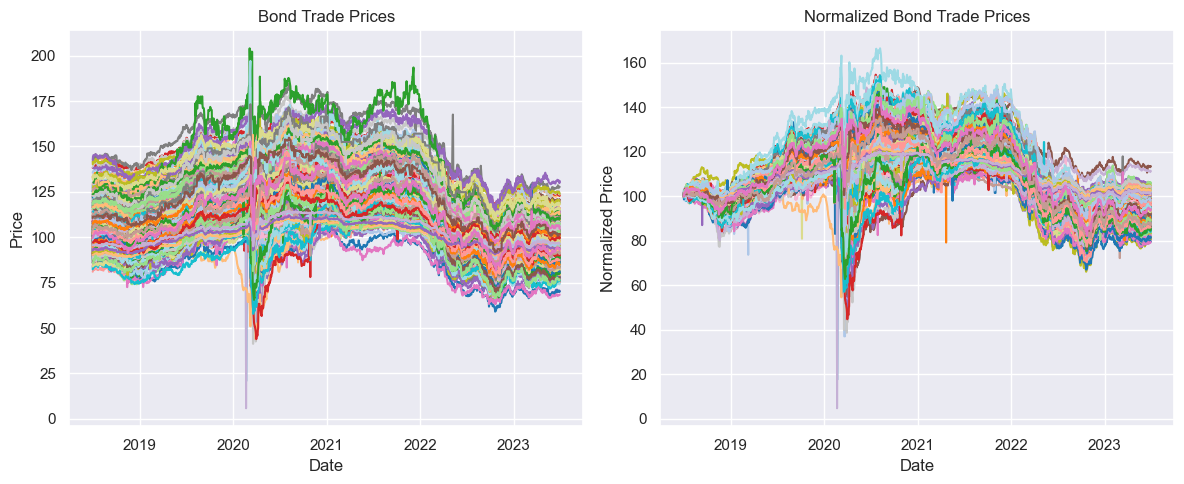

In [39]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_daily_full)
ax[0].set_title("Bond Trade Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

ax[1].plot(df_daily_full/df_daily_full.iloc[0] * 100)
ax[1].set_title("Normalized Bond Trade Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [40]:
total_returns_full = total_returns[full_data]
total_returns_full.head()

cusip          38141GFD1     126650CZ1     25156PAC7     111021AE1  \
trd_dt                                                               
2018-07-02  7.780367e-07  6.819063e-07  9.011904e-07  9.226310e-07   
2018-07-03  2.781766e-03  5.660640e-03  6.264048e-03  9.226310e-07   
2018-07-05  4.182788e-03  9.684003e-03  1.032216e-03  1.129991e-03   
2018-07-06  3.627488e-03  2.965216e-03  8.946594e-07  9.215913e-07   
2018-07-09  5.498889e-03  2.403384e-03  7.543287e-03 -5.817636e-04   

cusip          06051GHD4     126650CX6     35177PAL1     377372AE7  \
trd_dt                                                               
2018-07-02  4.969047e-07  5.977632e-07  8.423603e-07  6.790292e-07   
2018-07-03  1.351537e-03  2.978977e-03  8.423603e-07  1.061277e-02   
2018-07-05  5.966704e-04  1.805629e-03  5.147106e-03 -1.889337e-03   
2018-07-06 -1.400604e-05  4.021560e-03  8.380481e-07  3.360986e-03   
2018-07-09  8.512200e-04  3.549755e-04  2.514144e-06  4.266864e-04   

cusip          126650CY4     046353AD0  852060AT9     037833BX7     172967KA8  \
trd_dt                                                                          
2018-07-02  6.611995e-07  7.083340e-07   0.000001  5.917116e-07  6.197026e-07   
2018-07-03  7.514688e-03  7.083340e-07  -0.000984  7.887546e-03  2.425925e-03   
2018-07-05  3.099298e-03  1.416668e-06   0.004122  8.817655e-04  1.356672e-03   
2018-07-06  2.693932e-03  7.083340e-07  -0.001635  5.027763e-03  3.359500e-04   
2018-07-09  1.108036e-03  2.073968e-03   0.000159  6.072961e-03  1.381582e-03   

cusip          913017BT5     38141GWZ3     717081CY7     023135BC9  \
trd_dt                                                               
2018-07-02  6.236961e-07  5.877049e-07  7.118065e-07  4.508764e-07   
2018-07-03  5.937556e-03  8.471060e-04  7.118065e-07  4.508764e-07   
2018-07-05 -6.813550e-04  4.972256e-03  9.029683e-03  7.839542e-03   
2018-07-06  6.092197e-03  1.562722e-04  3.704764e-03  1.808595e-03   
2018-07-09  1.443442e-03  1.103886e-03  1.419843e-03 -4.535120e-04   

cusip          822582AD4     36186CBY8     437076AS1     126650CN8  \
trd_dt                                                               
2018-07-02  6.721330e-07  9.284610e-07  6.574972e-07  6.908420e-07   
2018-07-03 -1.294564e-03  8.430774e-03 -3.386134e-03  6.278042e-03   
2018-07-05  4.603407e-03 -2.716511e-03  3.878614e-03  1.395602e-02   
2018-07-06  3.813664e-03  9.232093e-07  1.092772e-02  1.740002e-03   
2018-07-09 -4.658080e-03  2.834537e-03 -1.071395e-03 -7.234425e-04   

cusip          617482V92     539439AQ2     92826CAF9     87938WAC7  \
trd_dt                                                               
2018-07-02  7.157499e-07  5.294579e-07  5.639057e-07  7.989260e-07   
2018-07-03  8.551806e-03  3.958849e-03  7.395752e-03  7.989260e-07   
2018-07-05  6.262077e-03  2.331169e-03  5.545905e-03  1.154284e-02   
2018-07-06  3.837827e-03  5.261444e-07  3.507068e-03  7.898106e-07   
2018-07-09  2.107710e-06  2.318653e-03  2.294634e-03 -1.968325e-03   

cusip          404280BT5     031162CF5     38141GGM0     161175BA1  \
trd_dt                                                               
2018-07-02  6.228860e-07  6.438734e-07  7.303369e-07  8.414918e-07   
2018-07-03  2.711709e-03  2.217353e-03  6.810548e-03  3.335046e-03   
2018-07-05  2.489328e-03  7.953369e-03  4.622408e-03  4.875818e-03   
2018-07-06  8.929229e-04  2.436600e-03  7.220604e-07  5.328240e-03   
2018-07-09  1.148978e-03 -6.890965e-05  3.244086e-03 -4.020609e-05   

cusip          983024AN0     46625HRY8     46625HHF0     00287YAM1  \
trd_dt                                                               
2018-07-02  6.669408e-07  5.319020e-07  7.116365e-07  6.324854e-07   
2018-07-03  6.530282e-03  2.623735e-03  7.116365e-07  1.007760e-03   
2018-07-05  2.763652e-03  1.688757e-03  6.021722e-03  7.116469e-03   
2018-07-06  2.208866e-03  2.221712e-03  8.044802e-03  6.273850e-07   
2018-07-09  1.115558e-03 -5.579590e-04 -3.951551e-04  7.819435e-03

In [42]:
full_tickers = list(df_characteristics_full["Ticker"].unique())
full_tickers = [i for i in full_tickers if i not in [None, 'RABO.AS', 'DISCA', 'ENBL', 'CLR']]
full_tickers.sort()

In [43]:
df_close_full = df_close[full_tickers]
df_close_full = df_close_full.drop([pd.Timestamp("2022-12-30")])
df_close_full.head()

AAPL       ABBV        ABT        ADI        AER  \
Date                                                                         
2018-07-02 00:00:00  44.601753  72.200836  55.612396  86.700455  53.770000   
2018-07-03 00:00:00  43.824955  72.588539  55.439167  85.080063  54.139999   
2018-07-05 00:00:00  44.177612  73.263191  55.913258  86.781487  54.480000   
2018-07-06 00:00:00  44.790005  75.155243  56.669945  87.501633  54.590000   
2018-07-09 00:00:00  45.411922  75.248314  56.925205  87.483643  55.349998   

                           AIG       ALLY       AMAT        AMGN         AMT  \
Date                                                                           
2018-07-02 00:00:00  45.763748  22.660582  42.707485  156.854813  128.505905   
2018-07-03 00:00:00  46.029606  22.575615  41.884735  157.210358  127.049103   
2018-07-05 00:00:00  46.244019  22.771029  42.483093  158.607117  129.394135   
2018-07-06 00:00:00  46.629955  22.898483  43.128197  161.696960  129.518524   
2018-07-09 00:00:00  47.650543  23.552727  43.492821  164.372025  126.294060   

                          AMZN  ATH-PA        ATO        AVGO        AWK  \
Date                                                                       
2018-07-02 00:00:00  85.689003     NaN  79.224205  202.352249  78.494125   
2018-07-03 00:00:00  84.697998     NaN  80.039772  200.044891  79.012497   
2018-07-05 00:00:00  84.986504     NaN  80.723816  205.152771  79.640045   
2018-07-06 00:00:00  85.531502     NaN  81.179832  207.058853  80.467613   
2018-07-09 00:00:00  86.950996     NaN  78.759415  206.849884  77.557419   

                           AXP        AZN        BAC  BAM        BCE  \
Date                                                                   
2018-07-02 00:00:00  91.516808  30.145588  24.780365  NaN  30.568251   
2018-07-03 00:00:00  90.444473  30.093645  24.342237  NaN  30.817945   
2018-07-05 00:00:00  91.409309  30.240826  24.464914  NaN  30.923878   
2018-07-06 00:00:00  91.400047  30.457266  24.561302  NaN  31.506487   
2018-07-09 00:00:00  92.689590  30.613104  25.455078  NaN  31.408123   

                          BCS         BDX        BHF        BHP        BIIB  \
Date                                                                          
2018-07-02 00:00:00  8.183775  216.404602  40.779999  33.283806  295.769989   
2018-07-03 00:00:00  8.142650  217.835876  40.599998  33.379742  293.510010   
2018-07-05 00:00:00  8.257801  219.375763  41.430000  33.366039  298.809998   
2018-07-06 00:00:00  8.266026  219.991760  41.709999  33.975929  357.480011   
2018-07-09 00:00:00  8.364724  221.622269  43.290001  34.832531  354.000000   

                            BK        BKR         BP       BRK-B     BTGOF  \
Date                                                                         
2018-07-02 00:00:00  46.011013  27.854946  33.344818  187.830002  2.256670   
2018-07-03 00:00:00  45.245438  28.150919  33.861237  186.020004  2.256670   
2018-07-05 00:00:00  45.253941  28.117090  33.934998  187.500000  2.295179   
2018-07-06 00:00:00  45.253941  28.472254  33.890747  187.559998  2.295179   
2018-07-09 00:00:00  46.028027  29.123390  34.377632  189.639999  2.403006   

                           BUD         BXP          C        CAH         CAT  \
Date                                                                           
2018-07-02 00:00:00  93.191277   99.711441  55.240463  40.918030  119.165634   
2018-07-03 00:00:00  93.960144   99.623466  54.335693  41.209419  117.014725   
2018-07-05 00:00:00  94.877243  100.814987  54.746941  41.658974  118.745941   
2018-07-06 00:00:00  96.192650  100.998894  55.224014  41.575710  118.396210   
2018-07-09 00:00:00  96.164871  100.790985  56.704552  41.842125  123.257622   

                             CB        CCI         CF        CHTR      CMCSA  \
Date                                                                           
2018-07-02 00:00:00  113.926300  87.991203  37.831604  293

In [44]:
df_volume_full = df_volume[full_tickers]
df_volume_full = df_volume_full.drop([pd.Timestamp("2022-12-30")])
df_volume_full.head()

AAPL     ABBV      ABT      ADI      AER      AIG  \
Date                                                                         
2018-07-02 00:00:00  70925200  3854500  4365200  2058400  1224800  5198800   
2018-07-03 00:00:00  55819200  2452400  2245200   876000   509300  1970500   
2018-07-05 00:00:00  66416800  4744000  4065200  1977700  1197000  2743800   
2018-07-06 00:00:00  69940800  5867400  3647900  1551000   824600  2212400   
2018-07-09 00:00:00  79026400  5953100  3654900  1861300   941600  4706400   

                        ALLY      AMAT     AMGN      AMT      AMZN  ATH-PA  \
Date                                                                         
2018-07-02 00:00:00  4001000  11042900  2069800  1559500  63714000     NaN   
2018-07-03 00:00:00  1143100   7538500  1348000  1669600  43546000     NaN   
2018-07-05 00:00:00  2933200   8950700  1801000  1512400  59662000     NaN   
2018-07-06 00:00:00  2047500  11467600  2751600  1376600  53006000     NaN   
2018-07-09 00:00:00  3105200   9727700  3065500  2334400  60240000     NaN   

                        ATO     AVGO     AWK      AXP      AZN       BAC  BAM  \
Date                                                                            
2018-07-02 00:00:00  353200  3336900  674900  3148700  4119700  52534300  NaN   
2018-07-03 00:00:00  373600  1159100  336000  2041200  1909600  40599000  NaN   
2018-07-05 00:00:00  328000  2529900  682700  2385500  3715700  44506800  NaN   
2018-07-06 00:00:00  271100  2311200  608300  1996600  2736100  39424900  NaN   
2018-07-09 00:00:00  564400  1795500  869400  4991700  2062500  61758900  NaN   

                         BCE      BCS     BDX      BHF      BHP      BIIB  \
Date                                                                        
2018-07-02 00:00:00   654100  2289600  827893  2140000  3397751   1116400   
2018-07-03 00:00:00   605800  1433000  696795   685000  1872631    452900   
2018-07-05 00:00:00  1541800  1921900  978875  1497700  2481446    746300   
2018-07-06 00:00:00  1442200  1312700  837733  1216300  2587829  12857000   
2018-07-09 00:00:00   843800  1861000  947920  1997500  2165996   3872800   

                          BK      BKR       BP    BRK-B  BTGOF      BUD  \
Date                                                                      
2018-07-02 00:00:00  4303100  3634600  4149900  3521000      0  1265200   
2018-07-03 00:00:00  2600900  2004600  3346600  2031200      0   789600   
2018-07-05 00:00:00  2976600  2406100  5301000  3310200   6700  1118800   
2018-07-06 00:00:00  3292900  2491800  2933500  2818800      0  1506700   
2018-07-09 00:00:00  2849600  2481900  5192400  3504700    100  1120200   

                        BXP         C      CAH      CAT       CB      CCI  \
Date                                                                        
2018-07-02 00:00:00  688900  12699100  3679400  3172600  1195100  2178600   
2018-07-03 00:00:00  397200  12346000  1857800  1837400  1171200  2165200   
2018-07-05 00:00:00  719800  12359000  3663000  3366300  1642500  2311300   
2018-07-06 00:00:00  478000  13174900  4756000  3179600  1393300  1795800   
2018-07-09 00:00:00  574500  15148500  3849900  5562300  1882400  2164600   

                          CF     CHTR     CMCSA      CME      CNQ      COF  \
Date                                                                         
2018-07-02 00:00:00  3049100   909600  17165000   917800  3178781  2460400   
2018-07-03 00:00:00  1363000   664300  12660800   512000  2688803   871100   
2018-07-05 00:00:00  3234600  1085000  11330300  1334500  3091282  1447700   
2018-07-06 00:00:00  2979100  1119300  11541300  1574300  2085903  1359100   
2018-07-09 00:00:00  2168800   900100  13664900  1651900  2926288  3123300   

                         COP      COR     COST       CP      CPB      CRM  \
Date                                                                        
2018-07-02 00:00:00  4952800  1260100  1876100  1517500 

In [45]:
first_non_null_values_full = {}
for column in df_close_full.columns:
    first_non_null_index = df_close_full[column].first_valid_index()
    if first_non_null_index is not None:
        first_non_null_values_full[column] = df_close_full.at[first_non_null_index, column]

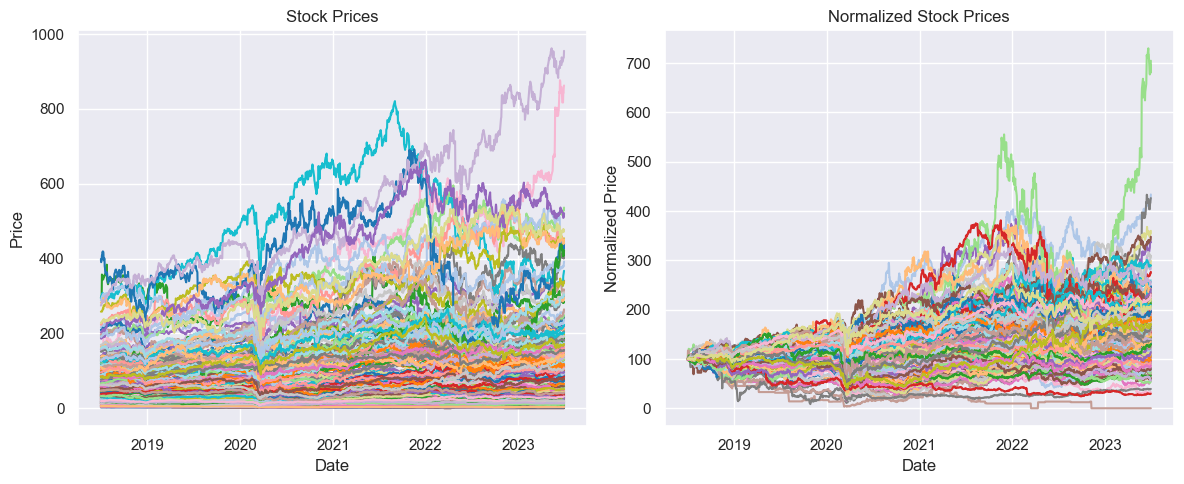

In [46]:
fig, ax = plt.subplots(1, 2, figsize = [12,5])

ax[0].plot(df_close_full)
ax[0].set_title("Stock Prices")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")
ax[0].grid(True)

df_stocks_normalized_full = df_close_full.dropna(axis = 1, how = "all") / first_non_null_values_full.values() * 100
for i in range(len(df_stocks_normalized_full.columns)):
    ax[1].plot(df_stocks_normalized_full.index, df_stocks_normalized_full[df_stocks_normalized_full.columns[i]], c = c20[(i+1)%20])
ax[1].set_title("Normalized Stock Prices")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Normalized Price")
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Calculating Factors

## Daily Bond Factors

In [47]:
def ytm(price, ttm, c):

    if price is None:
        return None

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    time = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    
    def f(y):
        return sum([coupon/(1 + y) ** t for t in time]) + 100 / (1 + y)**ttm - price

    max_iterations = 50 
    try:
        return newton(f, c, maxiter=max_iterations)
    except RuntimeError:
        return None

In [48]:
def closest_treasury(ttm):
    treasuries = [1, 2, 3, 5, 7, 10, 30]
    return min(treasuries, key = lambda x : abs(x - ttm))

In [49]:
def PV(ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] / ((1 + r) ** df["Time"])

    return sum(df["PV"])

In [50]:
def macaulay_duration(price, ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100

    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"]/((1 + r)**df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    duration = sum(df["Weight"]*df["Time"])
    return duration

In [51]:
def DV01(price, ttm, c, date):

    duration = macaulay_duration(price, ttm, c, date)

    if duration is None:
        return None
    else:
        return -1 * price * duration * .001

In [52]:
def convexity(price, ttm, c, date):

    periods = int(ttm * 2) + 1
    extra_time = ttm - int(ttm * 2)/2
    coupon = c * 100/2
    r = macro_factors[str(closest_treasury(ttm)) + "YRT"][date]/100
    
    df = pd.DataFrame()
    df["Time"] = [np.round((i/2) + extra_time, 4) for i in range(periods)]
    df = df[df["Time"] > 0]
    df["Cash Flow"] = coupon
    df["Cash Flow"].iloc[-1] = coupon + 100
    df["PV"] = df["Cash Flow"] /((1 + r) ** df["Time"])
    df["Weight"] = df["PV"]/sum(df["PV"]) 

    convexity = sum(df["Weight"]*(df["Time"]**2))
    return convexity

## Bond Level Factors

In [53]:
train_end = pd.Timestamp("2022-05-31")
len(df_daily[:train_end])

986

In [54]:
test_start = pd.Timestamp("2022-06-01")
len(df_daily[test_start:])

271

In [55]:
def illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["delta_t"] = df["Price"] - df["Price"].shift(1)
    df["delta_t1"] = df["Price"].shift(-1) - df["Price"]
    return -df["delta_t"].cov(df["delta_t1"])

In [56]:
def roll_illiquidity(bond):
    df = pd.DataFrame({"Price": bond})
    df["rd"] = df["Price"] - df["Price"].shift(1)
    df["rd1"] = df["rd"].shift()
    cov = -df["rd"].cov(df["rd1"])
    if cov < 0:
        return 0
    else:
        return 2*np.sqrt(cov)

In [57]:
def zero_return(returns):
    df = pd.DataFrame({"Returns": returns})
    return len(df[df["Returns"] == 0])/len(returns)

## Construct Factor Dataframe

In [58]:
df_characteristics_full = df_characteristics_full.sort_values("Cusip")
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  Weight  Amount_Issued  \
279  AT&T INC  00206RBH4 2042-12-15  19.0110    4.30    0.04      750000000   
463  AT&T INC  00206RBK7 2045-06-15  21.5123    4.35    0.03      900000000   
61   AT&T INC  00206RCP5 2035-05-15  11.4192    4.50    0.07     2250000000   
167  AT&T INC  00206RCQ3 2046-05-15  22.4274    4.75    0.05     1727815000   
595  AT&T INC  00206RCU4 2047-02-15  23.1836    5.65    0.02     1500000000   

           Industry       Location Accrual_Date Effective_Date Moody_Rating  \
279  Communications  United States   2013-06-15     2013-06-18         Baa3   
463  Communications  United States   2013-06-15     2013-06-18          Aa2   
61   Communications  United States   2015-05-04     2015-05-04           A3   
167  Communications  United States   2015-05-04     2015-05-04         Baa1   
595  Communications  United States   2016-02-09     2016-02-09           A3   

    S&P_Rating Fitch_Rating    TTM_Range      TFI Company Ticker  \
279       BBB-         BBB-  15-20 Years  10.5014    At&T      T   
463         A+         None    20+ Years  10.5014    At&T      T   
61        BBB+            A  10-15 Years   8.6247    At&T      T   
167       BBB+         None    20+ Years   8.6247    At&T      T   
595         A-            A    20+ Years   7.8548    At&T      T   

             Sector Sector Ticker  
279  Communications           XLY  
463  Communications           XLY  
61   Communications           XLY  
167  Communications           XLY  
595  Communications           XLY

In [59]:
data_full = daily_close_prices[daily_close_prices.index.droplevel(1).isin(full_data)]
data_full.head()

volume  Trades  Volume Weighted      Price
cusip     trd_dt                                                   
00206RBH4 2018-07-02  2643000.0      13     2.266502e+08  85.754886
          2018-07-03    49000.0       7     4.239176e+06  86.513796
          2018-07-05   951000.0      24     8.255477e+07  86.808383
          2018-07-06   678000.0      11     5.914873e+07  87.240021
          2018-07-09  2900000.0       7     2.527373e+08  87.150785

In [60]:
df = pd.DataFrame(total_returns[full_data].unstack()).sort_values(["cusip", "trd_dt"])
df.columns = ["Return"]
df.head()

Return
cusip     trd_dt                  
00206RBH4 2018-07-02  6.868892e-07
          2018-07-03  8.850444e-03
          2018-07-05  3.406442e-03
          2018-07-06  4.972987e-03
          2018-07-09 -1.020851e-03

In [61]:
df = df.merge(data_full[["Price", "volume", "Trades"]], on = ["cusip", "trd_dt"], how = "outer")
df = df.sort_values(["cusip", "trd_dt"])
df.head()

Return      Price     volume  Trades
cusip     trd_dt                                                
00206RBH4 2018-07-02  6.868892e-07  85.754886  2643000.0    13.0
          2018-07-03  8.850444e-03  86.513796    49000.0     7.0
          2018-07-05  3.406442e-03  86.808383   951000.0    24.0
          2018-07-06  4.972987e-03  87.240021   678000.0    11.0
          2018-07-09 -1.020851e-03  87.150785  2900000.0     7.0

In [62]:
def ticker_data(ticker, df, pct_change = True):
    if ticker not in df.columns:
        return [None] * 1257
    else:
        if pct_change == False:
            return df[ticker].fillna(0)
        else:
            return df[ticker].pct_change().fillna(0)

In [63]:
cpn, age, ttm, stock_return, stock_volume, etf_return = [], [], [], [], [], []

for i in df.index.droplevel(1).unique():
    cpn.extend([df_characteristics_full[df_characteristics_full["Cusip"] == i]["Coupon"].values[0]/100] * 1257)
    age.extend(list((df_daily.index - df_characteristics_full[df_characteristics_full["Cusip"] == i]["Effective_Date"].values[0]).days / 365))
    ttm.extend(list((df_characteristics_full[df_characteristics_full["Cusip"] == i]["Maturity"].values[0] - df_daily.index).days / 365))
    stock_return.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Ticker"].values[0], df_close_full)))
    stock_volume.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Ticker"].values[0], df_volume_full, pct_change = False)))
    etf_return.extend(list(ticker_data(df_characteristics_full[df_characteristics_full["Cusip"] == i]["Sector Ticker"].values[0], df_sector_etfs)))

cpn, age, ttm, stock_return, stock_volume, etf_return = list(cpn), list(age), list(ttm), list(stock_return), list(stock_volume), list(etf_return)

In [64]:
len(age)

946521

In [65]:
df["Coupon"] = cpn
df["Age"] = age
df["TTM"] = ttm
df["Stock_Return"] = stock_return
df["Stock_Volume"] = stock_volume
df["ETF_Return"] = etf_return
df.head()

Return      Price     volume  Trades  Coupon  \
cusip     trd_dt                                                           
00206RBH4 2018-07-02  6.868892e-07  85.754886  2643000.0    13.0   0.043   
          2018-07-03  8.850444e-03  86.513796    49000.0     7.0   0.043   
          2018-07-05  3.406442e-03  86.808383   951000.0    24.0   0.043   
          2018-07-06  4.972987e-03  87.240021   678000.0    11.0   0.043   
          2018-07-09 -1.020851e-03  87.150785  2900000.0     7.0   0.043   

                           Age        TTM  Stock_Return  Stock_Volume  \
cusip     trd_dt                                                        
00206RBH4 2018-07-02  5.041096  24.471233      0.000000    50002449.0   
          2018-07-03  5.043836  24.468493      0.015523    44857650.0   
          2018-07-05  5.049315  24.463014     -0.003363    46895286.0   
          2018-07-06  5.052055  24.460274      0.002454    54541518.0   
          2018-07-09  5.060274  24.452055      0.004123    57539848.0   

                      ETF_Return  
cusip     trd_dt                  
00206RBH4 2018-07-02    0.000000  
          2018-07-03   -0.005025  
          2018-07-05    0.004959  
          2018-07-06    0.007858  
          2018-07-09    0.011967

In [66]:
%%time

pv = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    pv.extend(df2.apply(lambda x: PV(x["TTM"], x["Coupon"], x.name), axis = 1).pct_change())
pv = list(pv)

CPU times: user 8min 31s, sys: 8.88 s, total: 8min 40s
Wall time: 8min 37s


In [67]:
ytms = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    ytms.extend(df2.apply(lambda x: ytm(x["Price"], x["TTM"], x["Coupon"]), axis = 1))
ytms = list(ytms)

In [68]:
durations = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    durations.extend(df2.apply(lambda x: macaulay_duration(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
durations = list(durations)

In [69]:
DV01s = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    DV01s.extend(df2.apply(lambda x: DV01(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
DV01s = list(DV01s)

In [70]:
convexitys = []
for i in df.index.droplevel(1).unique():
    df2 = df.loc[i]
    convexitys.extend(df2.apply(lambda x: convexity(x["Price"], x["TTM"], x["Coupon"], x.name), axis = 1))
convexitys = list(convexitys)

In [71]:
df["PV"] = pv
df["YTM"] = ytms
df["Duration"] = durations
df["DV01"] = DV01s
df["Convexity"] = convexitys
df = df.drop(["Coupon"], axis = 1)
df.head()

Return      Price     volume  Trades       Age  \
cusip     trd_dt                                                             
00206RBH4 2018-07-02  6.868892e-07  85.754886  2643000.0    13.0  5.041096   
          2018-07-03  8.850444e-03  86.513796    49000.0     7.0  5.043836   
          2018-07-05  3.406442e-03  86.808383   951000.0    24.0  5.049315   
          2018-07-06  4.972987e-03  87.240021   678000.0    11.0  5.052055   
          2018-07-09 -1.020851e-03  87.150785  2900000.0     7.0  5.060274   

                            TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                          
00206RBH4 2018-07-02  24.471233      0.000000    50002449.0    0.000000   
          2018-07-03  24.468493      0.015523    44857650.0   -0.005025   
          2018-07-05  24.463014     -0.003363    46895286.0    0.004959   
          2018-07-06  24.460274      0.002454    54541518.0    0.007858   
          2018-07-09  24.452055      0.004123    57539848.0    0.011967   

                            PV       YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                           
00206RBH4 2018-07-02       NaN  0.054328  16.324665 -1.399920  339.273017  
          2018-07-03  0.004849  0.053701  16.343155 -1.413908  339.790490  
          2018-07-05  0.001749  0.053476  16.344714 -1.418858  339.812463  
          2018-07-06  0.001668  0.053129  16.349071 -1.426293  339.925850  
          2018-07-09 -0.002931  0.053233  16.326755 -1.422890  339.254704

In [76]:
scaler = StandardScaler()
scaled_volume, scaled_stock_volume, scaled_trades, scaled_age, scaled_TTM = [], [], [], [], []
scaled_duration, scaled_YTM, scaled_DV01, scaled_convexity = [], [], [], []

for i in df.index.droplevel(1).unique():
    scaled_volume.extend(scaler.fit_transform(df.loc[i][["volume"]]))
    scaled_stock_volume.extend(scaler.fit_transform(df.loc[i][["Stock_Volume"]]))
    scaled_trades.extend(scaler.fit_transform(df.loc[i][["Trades"]]))
    scaled_age.extend(scaler.fit_transform(df.loc[i][["Age"]]))
    scaled_TTM.extend(scaler.fit_transform(df.loc[i][["TTM"]]))
    scaled_duration.extend(scaler.fit_transform(df.loc[i][["Duration"]]))
    scaled_YTM.extend(scaler.fit_transform(df.loc[i][["YTM"]]))
    scaled_DV01.extend(scaler.fit_transform(df.loc[i][["DV01"]]))
    scaled_convexity.extend(scaler.fit_transform(df.loc[i][["Convexity"]]))

df["volume"] =  [item for sublist in scaled_volume for item in sublist]
df["Stock_Volume"] =  [item for sublist in scaled_stock_volume for item in sublist]
df["Trades"] =  [item for sublist in scaled_trades for item in sublist]
df["Age"] =  [item for sublist in scaled_age for item in sublist]
df["TTM"] =  [item for sublist in scaled_TTM for item in sublist]
df["Duration"] =  [item for sublist in scaled_duration for item in sublist]
df["YTM"] =  [item for sublist in scaled_YTM for item in sublist]
df["DV01"] =  [item for sublist in scaled_DV01 for item in sublist]
df["Convexity"] =  [item for sublist in scaled_convexity for item in sublist]
df.head()

Return      Price    volume    Trades       Age  \
cusip     trd_dt                                                              
00206RBH4 2018-07-02  6.868892e-07  85.754886 -0.175980 -0.223827 -1.730577   
          2018-07-03  8.850444e-03  86.513796 -0.785507 -0.940150 -1.728678   
          2018-07-05  3.406442e-03  86.808383 -0.573559  1.089431 -1.724879   
          2018-07-06  4.972987e-03  87.240021 -0.637707 -0.462601 -1.722980   
          2018-07-09 -1.020851e-03  87.150785 -0.115591 -0.940150 -1.717283   

                           TTM  Stock_Return  Stock_Volume  ETF_Return  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02  1.730577      0.000000      0.043275    0.000000   
          2018-07-03  1.728678      0.015523     -0.171355   -0.005025   
          2018-07-05  1.724879     -0.003363     -0.086349    0.004959   
          2018-07-06  1.722980      0.002454      0.232636    0.007858   
          2018-07-09  1.717283      0.004123      0.357721    0.011967   

                            PV       YTM  Duration      DV01  Convexity  
cusip     trd_dt                                                         
00206RBH4 2018-07-02       NaN  0.969824  1.110695  0.556703   1.376428  
          2018-07-03  0.004849  0.902753  1.131115  0.498639   1.391850  
          2018-07-05  0.001749  0.878724  1.132837  0.478094   1.392504  
          2018-07-06  0.001668  0.841574  1.137649  0.447232   1.395884  
          2018-07-09 -0.002931  0.852737  1.113003  0.461360   1.375882

In [77]:
df = df[df.index.droplevel(0) > pd.Timestamp("2018-07-02")].drop(["Age"], axis = 1)
df.head()

Return      Price    volume    Trades       TTM  \
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.008850  86.513796 -0.785507 -0.940150  1.728678   
          2018-07-05  0.003406  86.808383 -0.573559  1.089431  1.724879   
          2018-07-06  0.004973  87.240021 -0.637707 -0.462601  1.722980   
          2018-07-09 -0.001021  87.150785 -0.115591 -0.940150  1.717283   
          2018-07-10  0.002972  87.409758 -0.519514 -0.462601  1.715383   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   
          2018-07-10      0.010887      0.103056    0.002150 -0.001502   

                           YTM  Duration      DV01  Convexity  
cusip     trd_dt                                               
00206RBH4 2018-07-03  0.902753  1.131115  0.498639   1.391850  
          2018-07-05  0.878724  1.132837  0.478094   1.392504  
          2018-07-06  0.841574  1.137649  0.447232   1.395884  
          2018-07-09  0.852737  1.113003  0.461360   1.375882  
          2018-07-10  0.830979  1.102112  0.447388   1.367151

In [79]:
df["Price"] = df["Price"].ffill()

In [ ]:
5.855022021880259

In [114]:
df[df.index.droplevel(1) == "92976GAJ0"].iloc[400:450]

Return       Price    volume    Trades       TTM  \
cusip     trd_dt                                                           
38141GFD1 2020-01-07 -0.007657  137.609357  2.497209  0.275331  0.678441   
          2020-01-08 -0.001304  137.429890  0.674776  0.180791  0.676542   
          2020-01-09  0.006882  138.375582  1.328693 -0.008288  0.674642   
          2020-01-10  0.008236  139.515122  0.790400  0.086251  0.672743   
          2020-01-13 -0.001817  139.261387  0.010438 -0.055558  0.667046   
          2020-01-14 -0.001426  139.062753  1.660720  0.369871  0.665147   
          2020-01-15  0.008694  140.271638  1.206931 -0.386447  0.663247   
          2020-01-16  0.000616  140.357890  1.596341  0.038982  0.661348   
          2020-01-17  0.007595  141.423833  2.040280 -0.102828  0.659449   
          2020-01-21  0.002927  141.837404  0.613253  0.275331  0.651852   
          2020-01-22  0.002076  142.131792  0.362306  0.038982  0.649953   
          2020-01-23 -0.001037  141.984344  0.329903  0.322601  0.648054   
          2020-01-24  0.002210  142.298063 -0.423794 -0.433717  0.646155   
          2020-01-27  0.003066  142.734005 -0.799215 -0.197368  0.640457   
          2020-01-28  0.000453  142.798631  0.735443 -0.055558  0.638558   
          2020-01-29  0.002850  143.205585  0.579279  0.133521  0.636659   
          2020-01-30 -0.000428  143.144243 -0.749396 -0.291908  0.634760   
          2020-01-31  0.000449  143.208491 -0.340573 -0.386447  0.632861   
          2020-02-03 -0.002071  142.911628  0.050407  0.133521  0.627163   
          2020-02-04 -0.006312  142.009446  1.672710  0.322601  0.625264   
          2020-02-05  0.002276  142.332548  0.925865  0.322601  0.623365   
          2020-02-06  0.002757  142.724853  0.836792  1.977046  0.621466   
          2020-02-07  0.006389  143.636586  0.701469 -0.150098  0.619567   
          2020-02-10  0.000073  143.646775 -0.370264 -0.433717  0.613869   
          2020-02-11 -0.002850  143.237342  0.078528 -0.008288  0.611970   
          2020-02-12 -0.006614  142.289809  9.983071  0.653490  0.610071   
          2020-02-13 -0.306658   98.655363  3.624328 -0.008288  0.608172   
          2020-02-14  0.456316  143.673285 -0.477894 -0.055558  0.606273   
          2020-02-18  0.001560  143.897007  1.317987  0.748030  0.598676   
          2020-02-19 -0.001458  143.687127  0.586131 -0.197368  0.596777   
          2020-02-20  0.001120  143.848021  0.818378 -0.102828  0.594878   
          2020-02-21 -0.856023   20.710648  2.376731 -0.102828  0.592978   
          2020-02-24  5.942531  143.784042 -0.527142 -0.197368  0.587281   
          2020-02-25 -0.001380  143.585543 -0.686017  0.180791  0.585382   
          2020-02-26 -0.006822  142.605928 -0.778088 -0.055558  0.583483   
          2020-02-27  0.003185  143.060032  0.339038  0.038982  0.581583   
          2020-02-28 -0.001113  142.900671 -0.716280 -0.291908  0.579684   
          2020-03-02  0.003924  143.461170  0.253534  0.322601  0.573987   
          2020-03-03  0.010495  144.966710  0.150186  0.038982  0.572088   
          2020-03-04 -0.004759  144.276738  0.868053  0.369871  0.570188   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
38141GFD1 2020-01-07      0.006583      1.587152   -0.000432 -0.002367   
          2020-01-08      0.009639      0.440851    0.010700 -0.004770   
          2020-01-09      0.020357      0.722934    0.011336  0.002468   
          2020-01-10     -0.002020     -0.451914   -0.002326  0.002467   
          2020-01-13      0.012804      0.301505    0.012507 -0.002262   
          2020-01-14      0.001835      0.941345   -0.004710  0.003678   
          2020-01-15     -0.001832      1.692933    0.001157  0.003679   
          2020-01-16      0.018392      0.714594    0.013447 -0.002363   
          2020-01-17     -0.001041      0.131441    0.006738 -0.003564   
          2020-01

In [105]:
plotting_data = df[["Price"]].unstack().T.droplevel(0)
plotting_data.head()

cusip       00206RBH4  00206RBK7  00206RCP5  00206RCQ3   00206RCU4  00206RDJ8  \
trd_dt                                                                          
2018-07-03  86.513796  85.764063  92.777224  90.303485  101.560580  86.711487   
2018-07-05  86.808383  85.934335  93.232962  90.663970  102.412667  87.573431   
2018-07-06  87.240021  86.341765  93.660107  91.439949  102.412667  87.806941   
2018-07-09  87.150785  86.970850  94.223017  91.555884  102.521000  88.317067   
2018-07-10  87.409758  87.083522  94.198859  91.373296  103.366494  88.202960   

cusip       00206RDK5  00206RDQ2   00206RDR0  002824BF6   002824BG4  \
trd_dt                                                                
2018-07-03  86.373563  98.487451   99.702791  98.607547  106.012000   
2018-07-05  87.524091  98.580550   99.926073  98.716870  106.840000   
2018-07-06  87.825117  98.839170  100.405647  99.016126  106.974145   
2018-07-09  87.825117  98.883799  100.147121  98.918538  107.060403   
2018-07-10  87.993155  99.139853  100.703049  98.956384  107.321000   

cusip        002824BH2  00287YAM1  00287YAR0   00287YAS8  00287YAV1  \
trd_dt                                                                
2018-07-03  108.658022  95.393000  98.154614   94.773054  96.096748   
2018-07-05  109.135716  96.071741  99.184341   99.991470  96.262823   
2018-07-06  109.874550  96.071741  99.318500   99.991470  96.777099   
2018-07-09  109.923346  96.822787  99.148051   99.991470  97.550418   
2018-07-10  110.281313  96.223585  99.556523  100.071774  96.902280   

cusip       00287YAW9   00440EAW7  00774MAB1  00817YAF5   00817YAZ1  \
trd_dt                                                                
2018-07-03  91.977414  103.016000  90.772000    91.8670  110.451875   
2018-07-05  96.482000  103.016000  90.772000   125.2480   89.662021   
2018-07-06  96.846005  103.016000  91.914000   125.6395   89.662021   
2018-07-09  96.905000  103.016000  91.610156   125.6085   89.662021   
2018-07-10  96.374915  103.629112  91.683500   125.6085   90.048000   

cusip        013716AU9  02209SAM5  02209SAR4  02209SAV5   023135AP1  \
trd_dt                                                                
2018-07-03  118.899000  93.107360  109.06577  88.722000   70.186192   
2018-07-05  123.206875  93.107360  109.06577  88.742882  110.164993   
2018-07-06  122.473539  93.915500  109.69300  89.535661  110.164993   
2018-07-09  122.473539  94.437686  109.66100  89.272609  110.717426   
2018-07-10  122.215000  93.927936  109.66100  89.794850  110.916000   

cusip        023135AQ9  023135BC9  023135BF2   023135BJ4   023135BM7  \
trd_dt                                                                 
2018-07-03  102.112527  95.704016  94.171401   98.422185   99.697360   
2018-07-05  113.243519  96.454205  98.782139   99.291128  100.298812   
2018-07-06  113.802221  96.628609  99.503935   99.843251  101.253945   
2018-07-09  113.802221  96.584657  99.677029  100.084562  101.041936   
2018-07-10  113.658062  96.583433  99.797133  100.109920  101.009433   

cusip       025816BF5  026874DF1  026874DL8  03027XAK6  03027XAP5  03040WAD7  \
trd_dt                                                                         
2018-07-03  97.825000  98.103605  88.763000  94.277000  93.534998  92.829232   
2018-07-05  97.825000  98.419876  97.305079  93.169446  93.458790  92.829232   
2018-07-06  97.825000  98.419876  97.305079  93.588425  93.702000  92.829232   
2018-07-09  99.109852  98.419876  97.572112  93.112808  93.702000  92.829232   
2018-07-10  98.704833  98.798903  98.156232  93.258336  93.429000  92.829232   

cusip        03040WAR6  03073EAP0  031162BZ2   031162CD0   031162CF5  \
trd_dt                                                                 
2018-07-03  112.687560  92.059889  97.221600   98.644125   99.362889   
2018-07-05  112.687560  93.336500  97.341537  100.522270  100.153031   
2018-07-06  112.687560  93.336500  97.893533  100.522270  100.397000   
2018-07-09   9

In [143]:
plotting_data.drop(bad_cusips, axis = 1)/plotting_data.drop(bad_cusips, axis = 1).iloc[0] * 100

cusip        00206RBH4   00206RBK7   00206RCP5   00206RCQ3   00206RCU4  \
trd_dt                                                                   
2018-07-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2018-07-05  100.340508  100.198535  100.491217  100.399192  100.838994   
2018-07-06  100.839432  100.673594  100.951616  101.258493  100.838994   
2018-07-09  100.736286  101.407100  101.558349  101.386877  100.945663   
2018-07-10  101.035628  101.538474  101.532310  101.184683  101.778165   
...                ...         ...         ...         ...         ...   
2023-06-26   97.488882   97.321596   99.191656   97.200831   98.587969   
2023-06-27   97.190913   96.705087   99.060681   97.435324   99.613699   
2023-06-28   97.857026   97.019186   99.048292   97.585471   99.630273   
2023-06-29   97.102105   96.217624   98.429667   96.925357   99.630273   
2023-06-30   98.060328   97.585279   99.042210   97.642324   99.630273   

cusip        00206RDJ8   00206RDK5   00206RDQ2   00206RDR0   002824BF6  \
trd_dt                                                                   
2018-07-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2018-07-05  100.994037  101.332037  100.094529  100.223947  100.110867   
2018-07-06  101.263332  101.680554  100.357121  100.704951  100.414349   
2018-07-09  101.851635  101.680554  100.402436  100.445654  100.315383   
2018-07-10  101.720042  101.875101  100.662422  101.003239  100.353763   
...                ...         ...         ...         ...         ...   
2023-06-26   96.975618   98.487129   99.045407   98.989559   99.358996   
2023-06-27   96.461796   98.224633   99.005105   97.733919   99.141254   
2023-06-28   97.000509   98.454232   99.061726   98.367196   99.081021   
2023-06-29   96.393793   97.820510   98.734410   97.389191   98.872827   
2023-06-30   97.106088   98.720857   98.791478   98.587608   98.962189   

cusip        002824BG4   002824BH2   00287YAM1   00287YAR0   00287YAS8  \
trd_dt                                                                   
2018-07-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2018-07-05  100.781044  100.439631  100.711520  101.049087  105.506224   
2018-07-06  100.907581  101.119594  100.711520  101.185768  105.506224   
2018-07-09  100.988947  101.164502  101.498838  101.012114  105.506224   
2018-07-10  101.234766  101.493946  100.870698  101.428266  105.590956   
...                ...         ...         ...         ...         ...   
2023-06-26   95.126209   92.777221   93.558422   96.600467   96.156684   
2023-06-27   94.796295   92.444688   93.194357   96.190565   96.111729   
2023-06-28   95.299812   92.455670   93.836739   96.744344   96.582030   
2023-06-29   94.130407   91.896313   93.836739   95.889242   95.259380   
2023-06-30   94.736919   92.759718   93.611956   96.554864   96.411286   

cusip        00287YAV1   00287YAW9   00440EAW7   00774MAB1   00817YAF5  \
trd_dt                                                                   
2018-07-03  100.000000  100.000000  100.000000  100.000000  100.000000   
2018-07-05  100.172820  104.897491  100.000000  100.000000  136.336225   
2018-07-06  100.707986  105.293246  100.000000  101.258097  136.762385   
2018-07-09  101.512715  105.357387  100.000000  100.923364  136.728640   
2018-07-10  100.838251  104.781066  100.595162  101.004164  136.728640   
...                ...         ...         ...         ...         ...   
2023-06-26   95.646963   96.029880   88.040296  101.319408  120.773905   
2023-06-27   95.241888   95.533111   87.367011  101.100397  120.700578   
2023-06-28   95.675632   96.093841   87.997638  101.345320  121.942746   
2023-06-29   94.883091   94.930774   87.318225  101.345320  119.286577   
2023-06-30   95.713347   96.281246   88.114468  101.206319  120.230197   

cusip        00817YAZ1   013716AU9   02209SAM5   02209SAR4   02209SAV5  \
trd_dt                                                                   


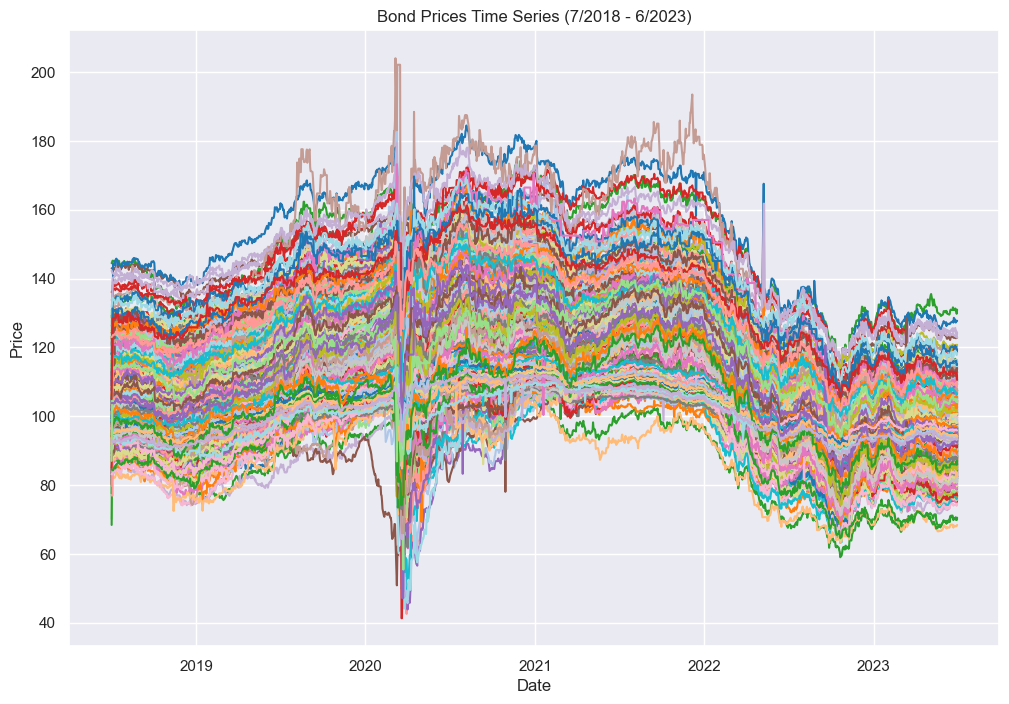

In [151]:
plt.figure(figsize = [12,8])
plt.plot(plotting_data.drop(bad_cusips, axis = 1))
plt.title("Bond Prices Time Series (7/2018 - 6/2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [141]:
bad_cusips = ["38141GFD1", "92976GAJ0", "902613AY4"]

In [187]:
df.head(3)

Return      Price    volume    Trades       TTM  \
cusip     trd_dt                                                          
00206RBH4 2018-07-03  0.008850  86.513796 -0.785507 -0.940150  1.728678   
          2018-07-05  0.003406  86.808383 -0.573559  1.089431  1.724879   
          2018-07-06  0.004973  87.240021 -0.637707 -0.462601  1.722980   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   

                           YTM  Duration      DV01  Convexity  
cusip     trd_dt                                               
00206RBH4 2018-07-03  0.902753  1.131115  0.498639   1.391850  
          2018-07-05  0.878724  1.132837  0.478094   1.392504  
          2018-07-06  0.841574  1.137649  0.447232   1.395884

In [89]:
df.to_pickle("factor_df.pkl")

## Individual Bond Analysis

In [607]:
def bond_dataset(cusip):

    cusip_info = df_characteristics_full[df_characteristics_full["Cusip"] == cusip]
    
    df_cusip = pd.DataFrame({"Price": df_daily[cusip]})
    df_cusip["Return"] = df_cusip.pct_change().fillna(0)
    df_cusip["Volume"] = daily_volume.loc[(slice(None), cusip), :].droplevel(1)
    df_cusip["Trades"] = daily_trades.loc[(slice(None), cusip), :].droplevel(1)
    df_cusip["Age"] = df_cusip.index.map(lambda x: (x - cusip_info["Effective_Date"].values[0]).days/365)
    df_cusip["TTM"] = df_cusip.index.map(lambda x: (cusip_info["Maturity"].values[0] - x).days/365)
    df_cusip["PV"] = df_cusip.apply(lambda x: PV(x["TTM"], cusip_info["Coupon"].values[0]/100, x.name), axis = 1).pct_change()
    df_cusip["YTM"] = df_cusip.apply(lambda x: ytm(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Duration"] = df_cusip.apply(lambda x: macaulay_duration(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["DV01"] = df_cusip.apply(lambda x: DV01(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Convexity"] = df_cusip.apply(lambda x: convexity(x["Price"], x["TTM"], cusip_info["Coupon"].values[0]/100), axis = 1)
    df_cusip["Stock Return"] = df_close_full[cusip_info["Ticker"].values[0]].pct_change()
    df_cusip["Stock Volume"] = df_volume_full[cusip_info["Ticker"].values[0]]
    df_cusip["ETF Return"] = df_sector_etfs[cusip_info["Sector Ticker"].values[0]].pct_change()

    df_cusip = pd.concat([df_cusip, macro_factors.drop(["Lower_Target", "Upper_Target"], axis = 1).pct_change()], axis = 1)
    df_cusip = df_cusip.iloc[1:].fillna(0).drop(["Price"], axis = 1)
    df_cusip["Cusip"] = cusip
    df_cusip = df_cusip.set_index(['Cusip'], append=True)

    return df_cusip

In [609]:
bond_dataset("25156PAC7").head()

Return      Volume  Trades        Age        TTM  \
           Cusip                                                           
2018-07-03 25156PAC7  0.007112   7016000.0    10.0  18.002740  11.958904   
2018-07-05 25156PAC7 -0.000975     70000.0     3.0  18.008219  11.953425   
2018-07-06 25156PAC7  0.000000         0.0     0.0  18.010959  11.950685   
2018-07-09 25156PAC7  0.003952  12017000.0    13.0  18.019178  11.942466   
2018-07-10 25156PAC7 -0.000208   4130000.0     6.0  18.021918  11.939726   

                            PV       YTM  Duration      DV01  Convexity  \
           Cusip                                                          
2018-07-03 25156PAC7  0.003423  0.050218  8.251392 -1.107616  84.426540   
2018-07-05 25156PAC7 -0.000681  0.050377  8.243381 -1.105462  84.298633   
2018-07-06 25156PAC7  0.001747  0.050394  8.240411 -1.105064  84.250224   
2018-07-09 25156PAC7 -0.003102  0.049942  8.239360 -1.109290  84.221778   
2018-07-10 25156PAC7 -0.000754  0.049986  8.235867 -1.108589  84.165465   

                      Stock Return  Stock Volume  ETF Return  EFFR      1YRT  \
           Cusip                                                               
2018-07-03 25156PAC7      0.015554      103100.0   -0.005025   0.0 -0.004274   
2018-07-05 25156PAC7      0.026165       84800.0    0.004959   0.0 -0.004292   
2018-07-06 25156PAC7      0.008706       78800.0    0.007858   0.0  0.008621   
2018-07-09 25156PAC7      0.001233       75100.0    0.011967   0.0  0.000000   
2018-07-10 25156PAC7      0.001232      104000.0    0.002150   0.0  0.008547   

                          2YRT      3YRT      5YRT      7YRT     10YRT  \
           Cusip                                                         
2018-07-03 25156PAC7 -0.015564 -0.007547 -0.010909 -0.014134 -0.013937   
2018-07-05 25156PAC7  0.007905  0.007605  0.007353  0.003584  0.003534   
2018-07-06 25156PAC7 -0.007843 -0.003774 -0.010949 -0.007143 -0.007042   
2018-07-09 25156PAC7  0.015810  0.007576  0.014760  0.014388  0.014184   
2018-07-10 25156PAC7  0.007782  0.011278  0.007273  0.003546  0.003497   

                         30YRT       SPY       LQD  
           Cusip                                    
2018-07-03 25156PAC7 -0.010033 -0.003531  0.003677  
2018-07-05 25156PAC7 -0.003378  0.008158  0.003140  
2018-07-06 25156PAC7 -0.003390  0.008458  0.001391  
2018-07-09 25156PAC7  0.006803  0.009004  0.000695  
2018-07-10 25156PAC7  0.003378  0.003598 -0.001128

In [264]:
def plot_bond(cusip):

    cusip_info = df_characteristics[df_characteristics["Cusip"] == cusip]
    initial_ttm = (pd.Timestamp(cusip_info["Maturity"].values[0]) - pd.Timestamp(cusip_info["Effective_Date"].values[0])).days/365

    fig, ax = plt.subplots(2, 2, figsize = [12,8])

    ax[0,0].plot(data[data["cusip"] == cusip]["trd_datetime"], 
                 data[data["cusip"] == cusip]["trd_px"], 
                 label = "Trade Prices", color = c20[0])
    ax[0,0].plot(df_daily[cusip], label = "Daily Close Price", color = c20[1])
    ax[0,0].set_title(cusip_info["Ticker"].values[0] + " " + str(int(round(initial_ttm, 1))) + "YR Corporate Bond Price (" + cusip + ")")
    ax[0,0].set_xlabel("Date")
    ax[0,0].set_ylabel("Price")
    ax[0,0].legend(loc = "lower left")

    ax[0,1].hist(df_daily_returns[cusip], bins = 50, color = c20[0])
    ax[0,1].set_title(cusip_info["Ticker"].values[0] + " " + str(int(round(initial_ttm, 1))) + "YR Corporate Bond Returns (" + cusip + ")")
    ax[0,1].set_xlabel("Daily Return")
    ax[0,1].set_xlim(-.1, .1)

    df = df_daily[cusip].diff()
    df.iloc[0] = 0
    plot_acf(df, lags=50, ax=ax[1, 0])

    ax[1,1].plot(df_daily_returns.index, df_daily_returns[cusip], color = c20[0])
    ax[1,1].set_title("Daily Returns")
    ax[1,1].set_xlabel("Daily Return")


    plt.tight_layout()
    plt.show()

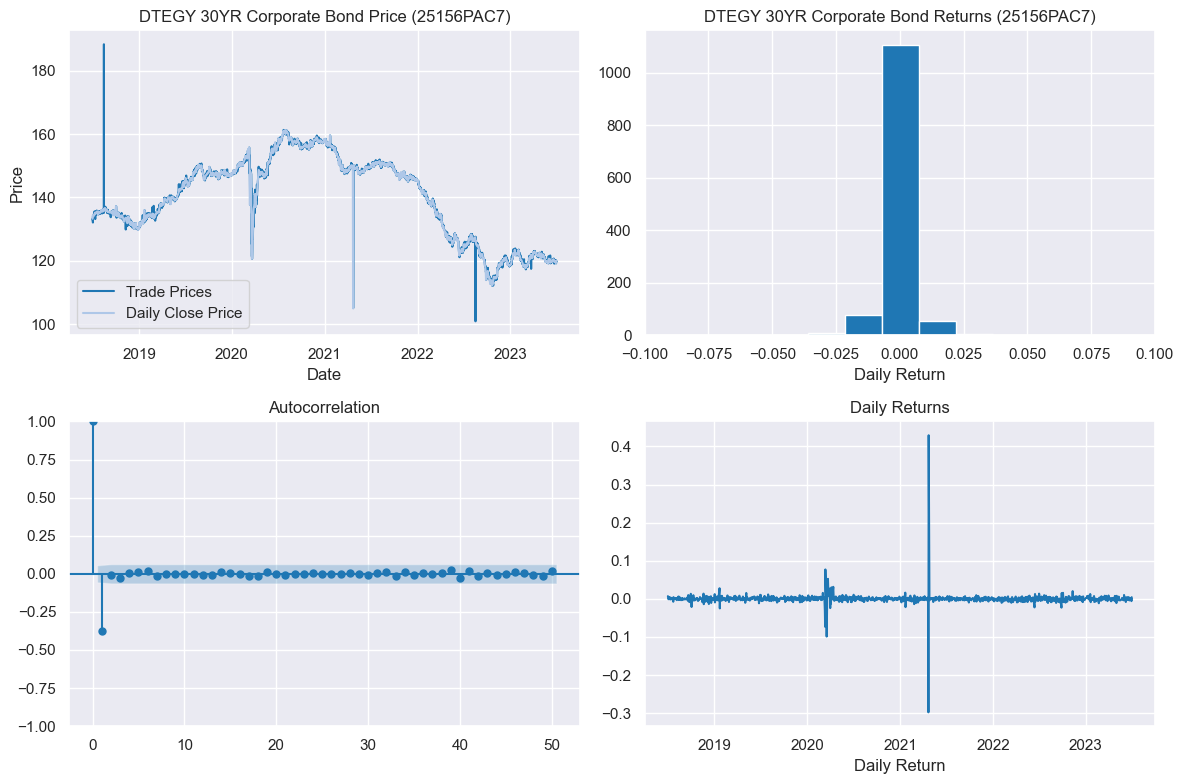

In [265]:
plot_bond("25156PAC7")

# Exploratory Data Analysis

In [59]:
df_characteristics_full.head()

Name      Cusip   Maturity      TTM  Coupon  \
0         GOLDMAN SACHS GROUP INC/THE  38141GFD1 2037-10-01  13.8137    6.75   
1                     CVS HEALTH CORP  126650CZ1 2048-03-25  24.3014    5.05   
2  DEUTSCHE TELEKOM INTERNATIONAL FIN  25156PAC7 2030-06-15   6.5123    8.75   
3      BRITISH TELECOMMUNICATIONS PLC  111021AE1 2030-12-15   7.0137    9.63   
4                BANK OF AMERICA CORP  06051GHD4 2028-12-20   5.0274    3.42   

   Weight  Amount_Issued               Industry        Location Accrual_Date  \
0    0.25     5545000000                Banking   United States   2007-10-03   
1    0.22     8000000000  Consumer Non-Cyclical   United States   2018-03-09   
2    0.21     3500000000         Communications         Germany   2000-07-06   
3    0.16     2800000000         Communications  United Kingdom   2000-12-12   
4    0.15     5437485000                Banking   United States   2017-12-20   

  Effective_Date Moody_Rating S&P_Rating Fitch_Rating    TTM_Range      TFI  \
0     2007-10-03         Baa2        BBB         BBB+  10-15 Years  16.2027   
1     2018-03-09         Baa2        BBB         None    20+ Years   5.7644   
2     2000-07-06         Baa1       BBB+         BBB+    5-7 Years  23.4493   
3     2000-12-12         Baa2        BBB          BBB   7-10 Years  23.0137   
4     2018-05-22           A3       BBB+         None    5-7 Years   5.5616   

                          Company Ticker          Sector Sector Ticker  
0                   Goldman Sachs     GS      Financials           XLK  
1                      Cvs Health    CVS     Health Care           XLF  
2  Deutsche Telekom International  DTEGY  Communications           XLY  
3      British Telecommunications  BTGOF  Communications           XLY  
4                 Bank Of America    BAC      Financials           XLK

In [60]:
df_characteristics_full.shape

(753, 20)

## Coupon

In [153]:
df_characteristics_full["Cpn_Range"] = pd.cut(df_characteristics_full["Coupon"], [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                         labels = ["2%", "3%", "4%", "5%", "6%", "7%", "8%", "9%"])

In [154]:
Coupon = df_characteristics_full.groupby("Cpn_Range").count()[["Cusip"]]
Coupon['Label'] = Coupon.index.map(lambda x: x if Coupon.loc[x]["Cusip"] > 25 else "")
Coupon['Color'] = c20[:8]
Coupon.head()

Cusip Label    Color
Cpn_Range                      
2%            36    2%  #1f77b4
3%           217    3%  #aec7e8
4%           293    4%  #ff7f0e
5%           113    5%  #ffbb78
6%            70    6%  #2ca02c

In [155]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Coupon["Cusip"], labels = Coupon["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Coupon')
plt.show()

## Sector/Location

In [156]:
Sector = df_characteristics_full.groupby("Sector").count()[["Cusip"]]
Sector['Label'] = Sector.index.map(lambda x: x if Sector.loc[x]["Cusip"] > 25 else "")
Sector = Sector.sort_values("Cusip", ascending = False)
Sector['Color'] = c20[:11]
Sector.head()

Cusip                   Label    Color
Sector                                                        
Financials                185              Financials  #1f77b4
Energy                    100                  Energy  #aec7e8
Health Care                94             Health Care  #ff7f0e
Consumer Discretionary     77  Consumer Discretionary  #ffbb78
Technology                 73              Technology  #2ca02c

In [157]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(Sector.index, Sector["Cusip"], color = Sector["Color"])
plt.xlabel('Number of Bonds')
plt.title('Sector Breakdown of Corporate Bonds in LQD')
ax.invert_yaxis()
plt.show()

In [158]:
Sector["Label"] = Sector["Label"].replace("Consumer Discretionary", "Discretionary")

fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Sector["Cusip"], labels = Sector["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by S&P Sector')
plt.show()

In [159]:
Industry = df_characteristics_full.groupby("Industry").count()[["Cusip"]]
Industry['Label'] = Industry.index.map(lambda x: x if Industry.loc[x]["Cusip"] > 25 else "")
Industry = Industry.sort_values("Cusip", ascending = False)
Industry['Color'] = c20[:18]
Industry.head()

Cusip                  Label    Color
Industry                                                    
Banking                  150                Banking  #1f77b4
Consumer Non-Cyclical    117  Consumer Non-Cyclical  #aec7e8
Energy                    97                 Energy  #ff7f0e
Communications            86         Communications  #ffbb78
Technology                69             Technology  #2ca02c

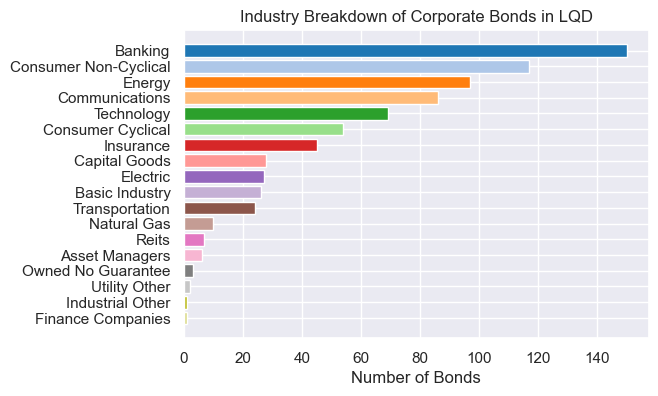

In [160]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(Industry.index, Industry["Cusip"], color = Industry["Color"])
plt.xlabel('Number of Bonds')
plt.title('Industry Breakdown of Corporate Bonds in LQD')
ax.invert_yaxis()
plt.show()

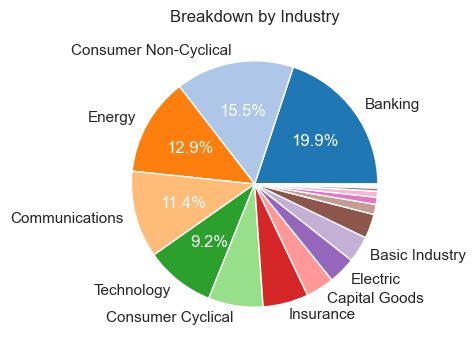

In [161]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Industry["Cusip"], labels = Industry["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Industry')
plt.show()

In [162]:
location = df_characteristics_full.groupby("Location").count()[["Cusip"]]
location['Label'] = location.index.map(lambda x: x if location.loc[x]["Cusip"] > 25 else "")
location = location.sort_values("Cusip", ascending = False)
location['Color'] = c20[:13]
location.head()

Cusip           Label    Color
Location                                      
United States     627   United States  #1f77b4
United Kingdom     32  United Kingdom  #aec7e8
Canada             30          Canada  #ff7f0e
Netherlands        14                  #ffbb78
Japan              12                  #2ca02c

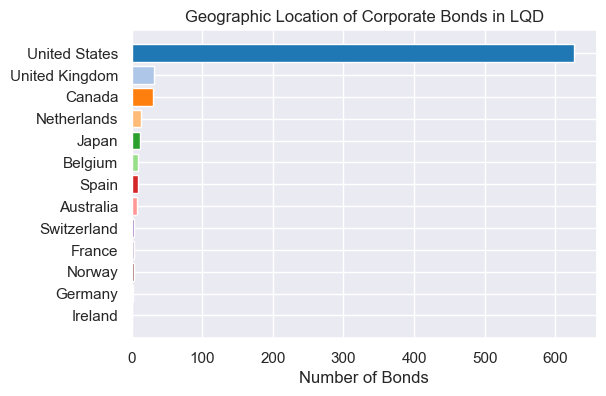

In [163]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(location.index, location["Cusip"], color = location["Color"])
plt.xlabel('Number of Bonds')
ax.invert_yaxis()
plt.title('Geographic Location of Corporate Bonds in LQD')
plt.show()

In [164]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(location["Cusip"], labels = location["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Location')
plt.show()

## Time to Maturity

In [165]:
TTM_Range = df_characteristics_full.groupby("TTM_Range").count()[["Cusip"]]
TTM_Range['Label'] = TTM_Range.index.map(lambda x: x if TTM_Range.loc[x]["Cusip"] > 25 else "")
TTM_Range['Color'] = c20[:7]
TTM_Range.head()

Cusip        Label    Color
TTM_Range                               
2-3 Years       37    2-3 Years  #1f77b4
3-5 Years      182    3-5 Years  #aec7e8
5-7 Years       18               #ff7f0e
7-10 Years      18               #ffbb78
10-15 Years    111  10-15 Years  #2ca02c

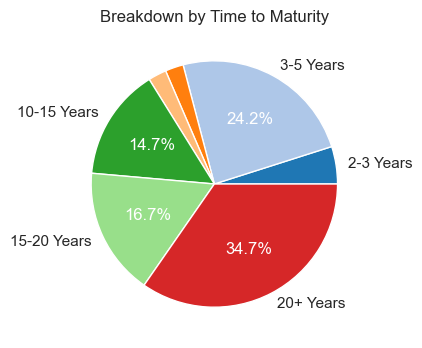

In [166]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(TTM_Range["Cusip"], labels = TTM_Range["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Time to Maturity')
plt.show()

## Effective Date

In [167]:
df_characteristics_full["TFI_Range"] = pd.cut(df_characteristics["TFI"], [0, 5, 7, 10, 15, 20, 100],
                                          labels = ["0-5 Years", "5-7 Years", "7-10 Years", "10-15 Years", "15-20 Years", "20+ Years"])

In [168]:
TFI_Range = df_characteristics_full.groupby("TFI_Range").count()[["Cusip"]]
TFI_Range['Label'] = TFI_Range.index.map(lambda x: x if TFI_Range.loc[x]["Cusip"] > 25 else "")
TFI_Range['Color'] = c20[:6]
TFI_Range.head()

Cusip        Label    Color
TFI_Range                               
0-5 Years      483    0-5 Years  #1f77b4
5-7 Years      114    5-7 Years  #aec7e8
7-10 Years      63   7-10 Years  #ff7f0e
10-15 Years     45  10-15 Years  #ffbb78
15-20 Years     32  15-20 Years  #2ca02c

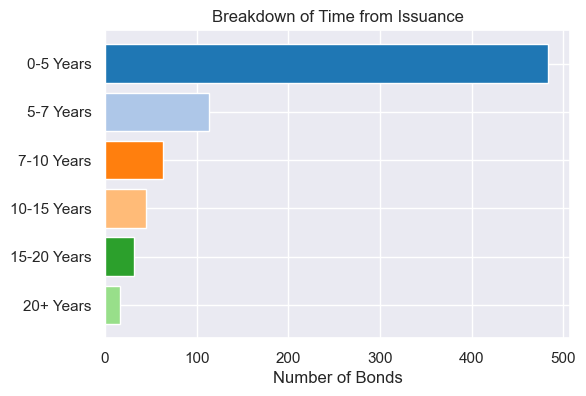

In [169]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(TFI_Range.index, TFI_Range["Cusip"], color = TFI_Range["Color"])
plt.xlabel('Number of Bonds')
plt.title('Breakdown of Time from Issuance')
ax.invert_yaxis()
plt.show()

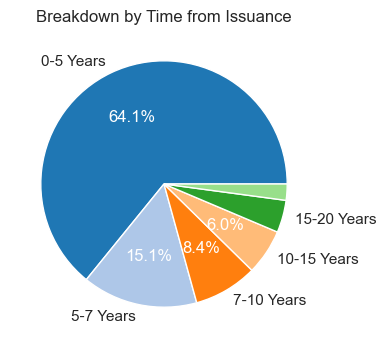

In [170]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(TFI_Range["Cusip"], labels = TFI_Range["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Time from Issuance')
plt.show()

## Credit Rating

In [171]:
bond_ratings = pd.DataFrame(columns = ["S&P", "Moody's", "Fitch", "Interpretation"])
bond_ratings["S&P"] = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "None"]
bond_ratings["Moody's"] = ["Aaa", "Aa1", "Aa2", "Aa3", "A1", "A2", "A3", "Baa1", "Baa2", "Baa3", "Ba1", "Ba2", "Ba3", "B1", "B2", "B3", "Caa1", "Caa2", "None"]
bond_ratings["Fitch"] = ["AAA", "AA+", "AA", "AA-", "A+", "A", "A-", "BBB+", "BBB", "BBB-", "BB+", "BB", "BB-", "B+", "B", "B-", "CCC+", "CCC", "None"]
bond_ratings["Interpretation"] = ["Prime", "High Investment Grade", "High Investment Grade", "High Investment Grade", 
                                  "Medium Investment Grade", "Medium Investment Grade", "Medium Investment Grade", "Low Investment Grade",
                                  "Low Investment Grade", "Low Investment Grade", "Non-Investment Grade", "Non-Investment Grade",
                                  "Non-Investment Grade", "Highly Speculative", "Highly Speculative", "Highly Speculative", 
                                  "Extremely Speculative", "Extremely Speculative", "No Rating"]
bond_ratings.head()

S&P Moody's Fitch           Interpretation
0  AAA     Aaa   AAA                    Prime
1  AA+     Aa1   AA+    High Investment Grade
2   AA     Aa2    AA    High Investment Grade
3  AA-     Aa3   AA-    High Investment Grade
4   A+      A1    A+  Medium Investment Grade

In [172]:
color_mapping = {
    'Prime': c20[2],
    'High Investment Grade': c20[3],
    'Medium Investment Grade': c20[0],
    'Low Investment Grade': c20[1],
    'Non-Investment Grade': c20[6],
    'Highly Speculative': c20[7],
    'No Rating': c10[7],
}

In [173]:
SP_dict = dict(zip(bond_ratings["S&P"], bond_ratings.index))
Moody_dict = dict(zip(bond_ratings["Moody's"], bond_ratings.index))
Fitch_dict = dict(zip(bond_ratings["Fitch"], bond_ratings.index))

In [174]:
def apply_order(x, rating):
    try:
        if rating == "Moody":
            return Moody_dict[x]
        elif rating == "S&P":
            return SP_dict[x]
        elif rating == "Fitch":
            return Fitch_dict[x]
    except:
        return "fail"

In [175]:
moody_ratings = df_characteristics_full.groupby("Moody_Rating").count()[["Cusip"]]
moody_ratings["Order"] = moody_ratings.index.map(lambda x: apply_order(x, "Moody"))
moody_ratings["Interpretation"] = moody_ratings.index.map(lambda x: bond_ratings[bond_ratings["Moody's"] == x]["Interpretation"].item())
moody_ratings = moody_ratings.sort_values("Order")
moody_ratings['Color'] = moody_ratings["Interpretation"].apply(lambda x: color_mapping[x])
moody_ratings['Label'] = moody_ratings.index.map(lambda x: x if moody_ratings.loc[x]["Cusip"] > 50 else "")
moody_ratings.head()

Cusip  Order           Interpretation    Color Label
Moody_Rating                                                      
Aaa              19      0                    Prime  #ff7f0e      
Aa2              16      2    High Investment Grade  #ffbb78      
Aa3              20      3    High Investment Grade  #ffbb78      
A1              128      4  Medium Investment Grade  #1f77b4    A1
A2              101      5  Medium Investment Grade  #1f77b4    A2

In [176]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(moody_ratings.index, moody_ratings["Cusip"], color=moody_ratings["Color"], label = moody_ratings["Interpretation"])
plt.xlabel('Number of Bonds')
plt.title('Breakdown by Moody Rating')
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list, loc = "upper right", fontsize = 7)
plt.show()

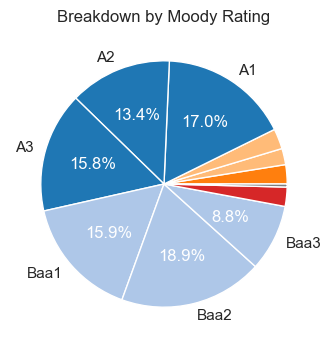

In [177]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(moody_ratings["Cusip"], labels = moody_ratings["Label"], 
                                  colors = moody_ratings["Color"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Moody Rating')
plt.show()

In [178]:
SP_ratings = df_characteristics_full.groupby("S&P_Rating").count()[["Cusip"]]
SP_ratings["Order"] = SP_ratings.index.map(lambda x: apply_order(x, "S&P"))
SP_ratings["Interpretation"] = SP_ratings.index.map(lambda x: bond_ratings[bond_ratings["S&P"] == x]["Interpretation"].item())
SP_ratings['Color'] = SP_ratings["Interpretation"].apply(lambda x: color_mapping[x])
SP_ratings['Label'] = SP_ratings.index.map(lambda x: x if SP_ratings.loc[x]["Cusip"] > 50 else "")
SP_ratings = SP_ratings.sort_values("Order")
SP_ratings.head()

Cusip  Order           Interpretation    Color Label
S&P_Rating                                                      
AAA             9      0                    Prime  #ff7f0e      
AA+            12      1    High Investment Grade  #ffbb78      
AA             14      2    High Investment Grade  #ffbb78      
AA-            28      3    High Investment Grade  #ffbb78      
A+             64      4  Medium Investment Grade  #1f77b4    A+

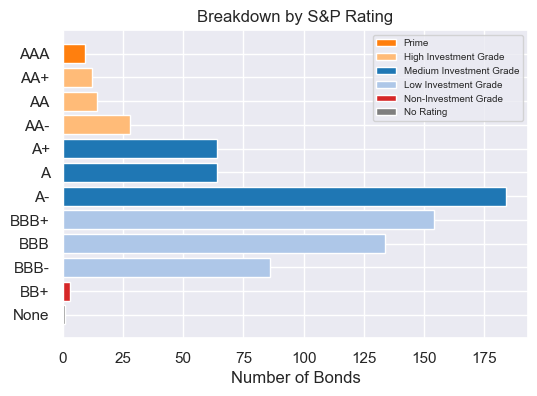

In [179]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(SP_ratings.index, SP_ratings["Cusip"], color=SP_ratings["Color"], label = SP_ratings["Interpretation"])
plt.xlabel('Number of Bonds')
plt.title('Breakdown by S&P Rating')
ax.invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
plt.legend(handle_list, label_list, loc = "upper right", fontsize = 7)
plt.show()

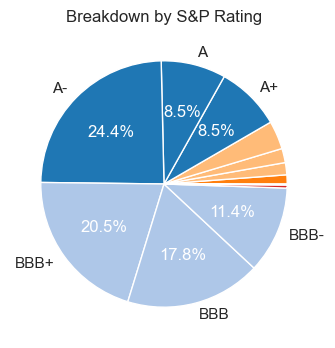

In [180]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(SP_ratings["Cusip"], labels = SP_ratings["Label"], 
                                  colors = SP_ratings["Color"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by S&P Rating')
plt.show()

In [181]:
Fitch_ratings = df_characteristics_full.groupby("Fitch_Rating").count()[["Cusip"]]
Fitch_ratings["Order"] = Fitch_ratings.index.map(lambda x: apply_order(x, "S&P"))
Fitch_ratings["Interpretation"] = Fitch_ratings.index.map(lambda x: bond_ratings[bond_ratings["Fitch"] == x]["Interpretation"].item())
Fitch_ratings = Fitch_ratings.sort_values("Order")
Fitch_ratings['Color'] = Fitch_ratings["Interpretation"].apply(lambda x: color_mapping[x])
Fitch_ratings['Label'] = Fitch_ratings.index.map(lambda x: x if Fitch_ratings.loc[x]["Cusip"] > 50 else "")
Fitch_ratings.head()

Cusip  Order           Interpretation    Color Label
Fitch_Rating                                                      
AA                4      2    High Investment Grade  #ffbb78      
AA-              52      3    High Investment Grade  #ffbb78   AA-
A+               31      4  Medium Investment Grade  #1f77b4      
A               107      5  Medium Investment Grade  #1f77b4     A
A-              109      6  Medium Investment Grade  #1f77b4    A-

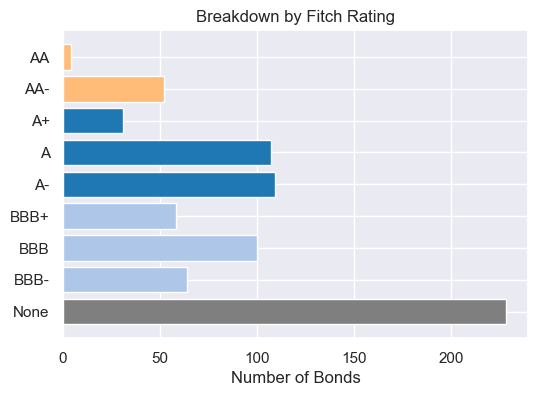

In [182]:
fig, ax = plt.subplots(figsize = [6,4])
plt.barh(Fitch_ratings.index, Fitch_ratings["Cusip"],
         color=[color_mapping[desc] for desc in Fitch_ratings['Interpretation']])
plt.xlabel('Number of Bonds')
plt.title('Breakdown by Fitch Rating')
ax.invert_yaxis()
plt.show()

In [183]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Fitch_ratings["Cusip"], labels = Fitch_ratings["Label"], 
                                  colors = Fitch_ratings["Color"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Fitch Rating')
plt.show()

## Output Graph

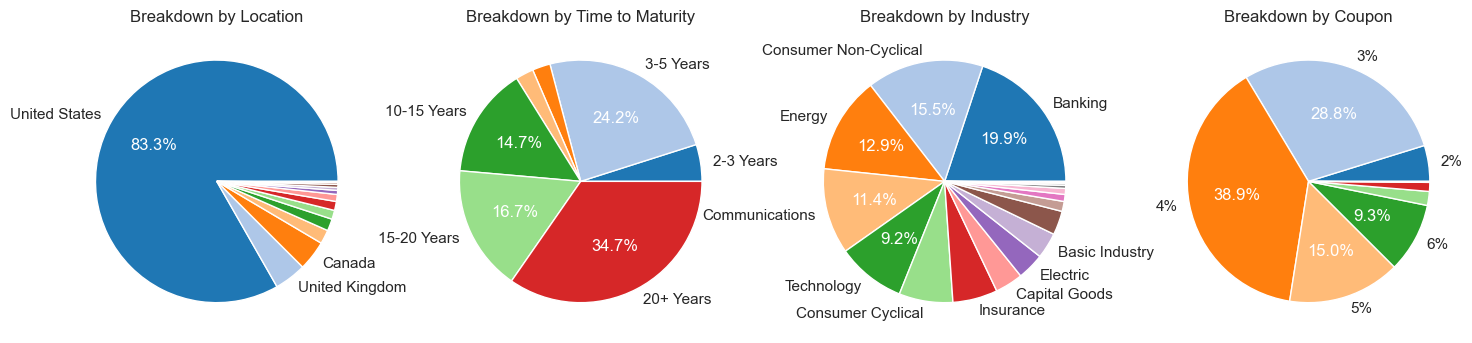

In [186]:
fig, ax = plt.subplots(1, 4, figsize = [18,6])
wedges, texts, autotexts = ax[0].pie(location["Cusip"], labels = location["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
ax[0].set_title('Breakdown by Location')

wedges, texts, autotexts = ax[1].pie(TTM_Range["Cusip"], labels = TTM_Range["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
ax[1].set_title('Breakdown by Time to Maturity')

wedges, texts, autotexts = ax[2].pie(Industry["Cusip"], labels = Industry["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
ax[2].set_title('Breakdown by Industry')

wedges, texts, autotexts = ax[3].pie(Coupon["Cusip"], labels = Coupon["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
ax[3].set_title('Breakdown by Coupon')



plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(TTM_Range["Cusip"], labels = TTM_Range["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 5 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Time to Maturity')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Industry["Cusip"], labels = Industry["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Industry')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = [6,4])
wedges, texts, autotexts = ax.pie(Coupon["Cusip"], labels = Coupon["Label"], 
                                  autopct=lambda p: format(p, '.1f')+"%" if p > 8 else None)
for autotext in autotexts:
    autotext.set_color("white")
plt.title('Breakdown by Coupon')
plt.show()